## Analysing the stock related tweets collected from Twitter and then building a price prediction model based on past two day's stock price and sentiment

### Importing the necessary libraries

In [1]:
import findspark

findspark.init("/Users/Monika/Documents/Apache_Spark/spark-3.1.1-bin-hadoop2.7")

#ref: https://kevinvecmanis.io/python/pyspark/install/2019/05/31/Installing-Apache-Spark.html
#'Users/vanaurum/server/spark-2.4.3-bin-hadoop2.7'

#ref: https://stackoverflow.com/questions/49063058/py4j-error-when-creating-a-spark-dataframe-using-pyspark/55921339
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.sql.functions import udf
from pyspark.sql.types import *


import re
from pyspark.ml.pipeline import PipelineModel

from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Tokenizer,Word2Vec,StopWordsRemover,StringIndexer


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Validating that the pyspark is properly imported by creating a dummy dataframe

spark = SparkSession.builder.getOrCreate()
df = spark.createDataFrame([{"a": "x", "b": "y", "c": "3"}])

In [3]:
df.printSchema()

root
 |-- a: string (nullable = true)
 |-- b: string (nullable = true)
 |-- c: string (nullable = true)



## Connecting to Mongo DB and fetching the data

In [4]:
spark = SparkSession \
    .builder \
    .appName('myApp') \
    .config('spark.mongodb.input.uri', 'mongodb://127.0.0.1/stock_tweets.twitter_search') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:3.0.1')\
    .getOrCreate()



In [5]:
#Reading the data from Mongo DB
df = spark.read.format('mongo').option('uri', 'mongodb://127.0.0.1/stock_tweets.twitter_search').load()

In [6]:
#Printing the data frame'schema
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- stock: string (nullable = true)
 |-- tweet: string (nullable = true)



In [7]:
print("Count of rows before dropping the duplicates: ", df.select("created_at","stock","tweet").count())
df = df.select("created_at","stock","tweet").drop_duplicates() #dropping the duplicate tweets
print("Count of rows after dropping the duplicates: ", df.count())

Count of rows before dropping the duplicates:  357684
Count of rows after dropping the duplicates:  209388


In [8]:
print("The dataframe contains:")
df.show()

The dataframe contains:
+-------------------+-----+--------------------+
|         created_at|stock|               tweet|
+-------------------+-----+--------------------+
|2021-03-12 21:16:54|   ZM|#SAWW
💥FB Team💯...|
|2021-03-12 21:01:24|   ZM|#SAWW
💥FB Team💯...|
|2021-03-12 19:35:38|   ZM|CBD of Denver Inc...|
|2021-03-12 16:56:26|   ZM|Seeing my mother ...|
|2021-03-12 16:39:49|   ZM|Gearboxes, sandst...|
|2021-03-12 16:24:22|   ZM|@JamesDAttwood I’...|
|2021-03-12 15:48:56|   ZM|@_Lebsky Hi Felix...|
|2021-03-12 15:19:32|   ZM|@alwaysbeenxime 2...|
|2021-03-12 23:27:01| OKTA|Doubling Down on ...|
|2021-03-12 11:17:49| OKTA|We’re sponsoring ...|
|2021-03-12 19:26:22| FVRR|Fiverr Internatio...|
|2021-03-12 23:59:43| TSLA|Great post detail...|
|2021-03-12 14:47:28| TSLA|$tsla calls for n...|
|2021-03-12 14:20:35| TSLA|GAME On Today!
Ov...|
|2021-03-12 13:32:59| TSLA|*TESLA SHARES FAL...|
|2021-03-12 22:25:10| AAPL|Friday option vol...|
|2021-03-12 21:03:46| AAPL|Lots of buy volum...|


In [10]:
#Writing the data from dataframe into a csv file
#df.select("created_at","stock","tweet").toPandas().to_csv("CSV_File__Stock_Tweets_until_May_05_2021.csv")

In [11]:
sample_tweet = df.select(df["created_at"], df["tweet"]).collect()[1995]
print("********\tSample Tweet \t***********\n")
print("Tweet posted on: ", sample_tweet[0])
print("Tweet:\n", sample_tweet[1])

********	Sample Tweet 	***********

Tweet posted on:  2021-05-03 14:27:24
Tweet:
 Our long awaited website is finally here and it’s beautiful &amp; world-class: https://t.co/g1WTJqIg1J So excited for it &amp; for the growth that happens from here. Thanks too for the support @prosperozm 🙏🏾 #zambia #tourism #newwebsite #digitalmedia #marketingsolutions


## Cleaning the data

In [12]:
import re

#Functions to clean the tweets

def clean_pattern(text, pattern):
    """
    Function to identify the given pattern in a string and remove all the occurences
    """
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, '', text)        
    return text

def clean_tweet(text):
    
    """
      Function to remove tweet mentions, retweet tags, URL's, numbers and special characters
    """
    text = clean_pattern(text, 'RT @[\w]*:')

    text = clean_pattern(text, '@[\w]*')
    
    text = clean_pattern(text, 'https?://[A-Za-z0-9./]*')

    text = re.sub('[^A-Za-z]+', ' ', text)
    
    return text

In [13]:
#Creating a user defined function to clean the tweets collected

clean_tweet_udf = udf(clean_tweet,StringType()) #defining the return type as string

df = df.withColumn("cleaned_tweet", clean_tweet_udf("tweet"))

In [14]:
print("Data franme after cleaning the tweets: ")
df.show()

Data franme after cleaning the tweets: 
+-------------------+-----+--------------------+--------------------+
|         created_at|stock|               tweet|       cleaned_tweet|
+-------------------+-----+--------------------+--------------------+
|2021-03-12 21:16:54|   ZM|#SAWW
💥FB Team💯...|       SAWW FB Team |
|2021-03-12 21:01:24|   ZM|#SAWW
💥FB Team💯...|       SAWW FB Team |
|2021-03-12 19:35:38|   ZM|CBD of Denver Inc...|CBD of Denver Inc...|
|2021-03-12 16:56:26|   ZM|Seeing my mother ...|Seeing my mother ...|
|2021-03-12 16:39:49|   ZM|Gearboxes, sandst...|Gearboxes sandsto...|
|2021-03-12 16:24:22|   ZM|@JamesDAttwood I’...| I m being glib I...|
|2021-03-12 15:48:56|   ZM|@_Lebsky Hi Felix...| Hi Felix we love...|
|2021-03-12 15:19:32|   ZM|@alwaysbeenxime 2...| I VoteShawnMende...|
|2021-03-12 23:27:01| OKTA|Doubling Down on ...|Doubling Down on ...|
|2021-03-12 11:17:49| OKTA|We’re sponsoring ...|We re sponsoring ...|
|2021-03-12 19:26:22| FVRR|Fiverr Internatio...|Fiverr

In [15]:
df.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- stock: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- cleaned_tweet: string (nullable = true)



In [16]:
from pyspark.sql.functions import to_timestamp

#Extracting the date from the created datetime column

df = df.withColumn("created_date" , to_date(to_timestamp(df.created_at, 'yyyy-MM-dd HH:mm:ss')))

In [17]:
df.show()

+-------------------+-----+--------------------+--------------------+------------+
|         created_at|stock|               tweet|       cleaned_tweet|created_date|
+-------------------+-----+--------------------+--------------------+------------+
|2021-03-12 21:16:54|   ZM|#SAWW
💥FB Team💯...|       SAWW FB Team |  2021-03-12|
|2021-03-12 21:01:24|   ZM|#SAWW
💥FB Team💯...|       SAWW FB Team |  2021-03-12|
|2021-03-12 19:35:38|   ZM|CBD of Denver Inc...|CBD of Denver Inc...|  2021-03-12|
|2021-03-12 16:56:26|   ZM|Seeing my mother ...|Seeing my mother ...|  2021-03-12|
|2021-03-12 16:39:49|   ZM|Gearboxes, sandst...|Gearboxes sandsto...|  2021-03-12|
|2021-03-12 16:24:22|   ZM|@JamesDAttwood I’...| I m being glib I...|  2021-03-12|
|2021-03-12 15:48:56|   ZM|@_Lebsky Hi Felix...| Hi Felix we love...|  2021-03-12|
|2021-03-12 15:19:32|   ZM|@alwaysbeenxime 2...| I VoteShawnMende...|  2021-03-12|
|2021-03-12 23:27:01| OKTA|Doubling Down on ...|Doubling Down on ...|  2021-03-12|
|2021-03

In [18]:
from pyspark.sql.functions import unix_timestamp, lit
df.filter(df.created_date == '2021-03-12').count()

4236

In [19]:
count_tweets_per_day_stock = df.groupBy(["created_date","stock"]).count().toPandas()

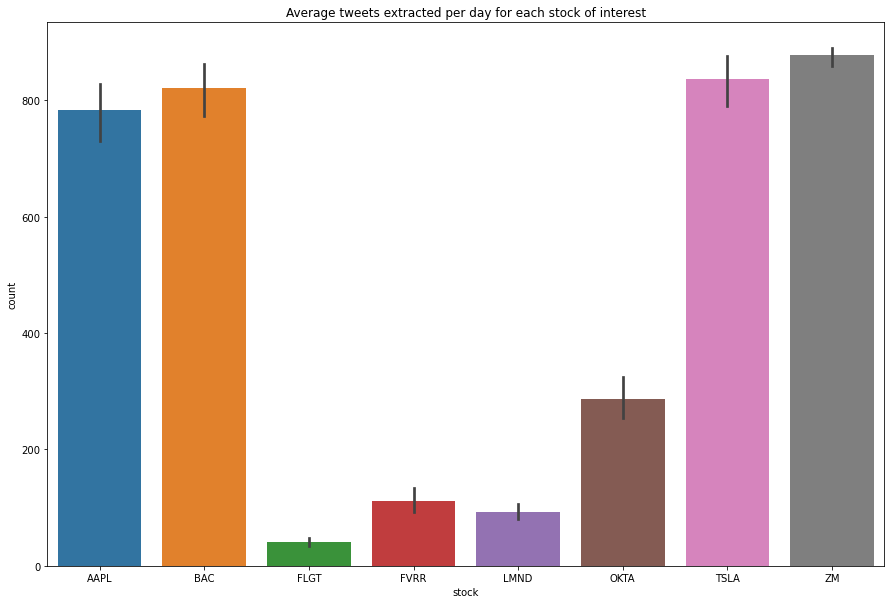

In [20]:

plt.figure(figsize=(15,10))
sns.barplot(data=count_tweets_per_day_stock, y="count",x="stock",order=np.sort(count_tweets_per_day_stock["stock"].unique()))
plt.title("Average tweets extracted per day for each stock of interest")
plt.show()

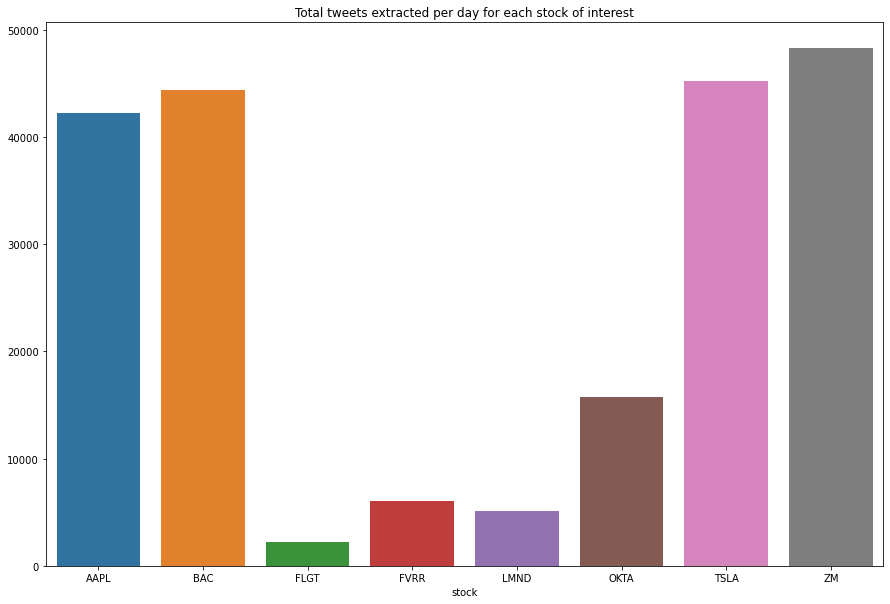

In [21]:
plt.figure(figsize=(15,10))
sns.barplot(y=count_tweets_per_day_stock.groupby("stock")["count"].sum().values,x=count_tweets_per_day_stock.groupby("stock")["count"].sum().index)
plt.title("Total tweets extracted per day for each stock of interest")
plt.show()

In [22]:
#ref: https://stackoverflow.com/questions/49301373/pyspark-filter-dataframe-based-on-multiple-conditions
#ref: https://sparkbyexamples.com/pyspark/pyspark-where-filter/

df.filter((df.created_date == '2021-03-22') & (df.stock=="LMND")).show()

+-------------------+-----+--------------------+--------------------+------------+
|         created_at|stock|               tweet|       cleaned_tweet|created_date|
+-------------------+-----+--------------------+--------------------+------------+
|2021-03-22 13:13:15| LMND|Tickers with the ...|Tickers with the ...|  2021-03-22|
|2021-03-22 21:23:12| LMND|@ParrotStock @tmf...| I was watching L...|  2021-03-22|
|2021-03-22 08:18:56| LMND|$LMND If you had ...| LMND If you had ...|  2021-03-22|
|2021-03-22 11:45:47| LMND|$LMND  another di...| LMND another dis...|  2021-03-22|
|2021-03-22 00:46:33| LMND|@BahamaBen9 $LMND...| LMND amp DMTK fo...|  2021-03-22|
|2021-03-22 12:11:21| LMND|5/31 - Lemonade $...| Lemonade LMND Th...|  2021-03-22|
|2021-03-22 02:09:46| LMND|@BahamaBen9 $LMND...| LMND amp DMTK fo...|  2021-03-22|
|2021-03-22 14:14:22| LMND|Portfolio update:...|Portfolio update ...|  2021-03-22|
|2021-03-22 23:49:03| LMND|$LMND Will Be Con...| LMND Will Be Con...|  2021-03-22|
|202

In [23]:
df.count()

209388

## Creating a pipeline to clean and transform the textual tweets to vectors

In [24]:
tokenizer = Tokenizer(inputCol='cleaned_tweet', outputCol='tokenized_tweet')
stop_words = StopWordsRemover.loadDefaultStopWords("english")
stop_words.remove("not")
stopword_remover = StopWordsRemover(inputCol='tokenized_tweet',outputCol='cleaned_tokens',stopWords=stop_words)
word2Vec = Word2Vec(vectorSize=100, minCount=2, inputCol='cleaned_tokens', outputCol='features')

In [25]:
#Defining the pipeline
data_cleaning_model = Pipeline(stages=[tokenizer,stopword_remover,word2Vec])

In [26]:
cleaned_stock_tweets = data_cleaning_model.fit(df)

In [27]:
cleaned_stock_tweets = cleaned_stock_tweets.transform(df)

## Loading the previously created sentiment classifier ml model

In [28]:
from pyspark.ml.classification import LogisticRegressionModel

In [29]:
#ref: https://stackoverflow.com/questions/45442918/save-and-load-two-ml-models-in-pyspark
sentiment_analyser = LogisticRegressionModel.load("Sentiment_analyser.model")

In [30]:
cleaned_stock_tweets.select("tweet").show(2,False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                                                                                                                                                                                                                        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|#SAWW
💥FB Team💯💥
@Nysar7
@TM_YZ1
@zm_444
@78Kh6
@AAJZI_2
@sh_kh98
@Satti_01
@1fttr
💥
@S

## Predicting the sentiment based on the ml model created

In [31]:
analysed_tweets = sentiment_analyser.transform(cleaned_stock_tweets)

In [32]:
analysed_tweets.show()

+-------------------+-----+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|         created_at|stock|               tweet|       cleaned_tweet|created_date|     tokenized_tweet|      cleaned_tokens|            features|       rawPrediction|         probability|prediction|
+-------------------+-----+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|2021-03-12 21:16:54|   ZM|#SAWW
💥FB Team💯...|       SAWW FB Team |  2021-03-12|  [, saww, fb, team]|  [, saww, fb, team]|[0.07480707019567...|[1.08156774398102...|[0.74679054966574...|       0.0|
|2021-03-12 21:01:24|   ZM|#SAWW
💥FB Team💯...|       SAWW FB Team |  2021-03-12|  [, saww, fb, team]|  [, saww, fb, team]|[0.07480707019567...|[1.08156774398102...|[0.74679054966574...|       0.0|
|2021-03-

### Sampling the negative sentiment tweets for Tesla stock

In [33]:
analysed_tweets.filter((analysed_tweets.prediction==0) & (analysed_tweets.stock=="TSLA" )).select("tweet","prediction").show(2,False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|tweet                                                                                                                                                                                                                                                                                   |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|Great post detailing what happened to $GOEV today with that massive drop. 
Tl;dr: call volume went insane, algo kicke

### Sampling the positive sentiment tweets for Tesla stock

In [34]:
analysed_tweets.filter((analysed_tweets.prediction==1) & (analysed_tweets.stock=="TSLA" )).select("tweet","prediction").show(2,False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|tweet                                                                                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|One of the best discussions of $tsla I've heard in a while. Nice job @WholeMarsBlog and @Gfilche 👏👏 

https://t.co/nryZrDqycg                                                                            |1.0       |
|Tesla, Inc. (TSLA) surprised the market with Q3 result. Credit Suisse changed the rating to Hold, as Tesla, Inc. (TSLA) has negative 

In [35]:
#Converting the created_date to a date type column
analysed_tweets= analysed_tweets.withColumn("dates",to_date(analysed_tweets["created_date"]))

In [36]:
dates= analysed_tweets.select("created_date").distinct().sort("created_date").collect()

dates_list = []
import datetime
for x in dates:
    dates_list.append(str(x["created_date"]))

In [37]:
dates_list

['2021-03-12',
 '2021-03-13',
 '2021-03-14',
 '2021-03-15',
 '2021-03-16',
 '2021-03-17',
 '2021-03-18',
 '2021-03-19',
 '2021-03-20',
 '2021-03-21',
 '2021-03-22',
 '2021-03-23',
 '2021-03-24',
 '2021-03-25',
 '2021-03-26',
 '2021-03-27',
 '2021-03-28',
 '2021-03-29',
 '2021-03-30',
 '2021-03-31',
 '2021-04-01',
 '2021-04-02',
 '2021-04-03',
 '2021-04-04',
 '2021-04-05',
 '2021-04-06',
 '2021-04-07',
 '2021-04-08',
 '2021-04-09',
 '2021-04-10',
 '2021-04-11',
 '2021-04-12',
 '2021-04-13',
 '2021-04-14',
 '2021-04-15',
 '2021-04-16',
 '2021-04-17',
 '2021-04-18',
 '2021-04-19',
 '2021-04-20',
 '2021-04-21',
 '2021-04-22',
 '2021-04-23',
 '2021-04-24',
 '2021-04-25',
 '2021-04-26',
 '2021-04-27',
 '2021-04-28',
 '2021-04-29',
 '2021-04-30',
 '2021-05-01',
 '2021-05-02',
 '2021-05-03',
 '2021-05-04',
 '2021-05-05']

In [38]:
analysed_tweets.filter(analysed_tweets["dates"]=="2021-03-20").show()

+-------------------+-----+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+
|         created_at|stock|               tweet|       cleaned_tweet|created_date|     tokenized_tweet|      cleaned_tokens|            features|       rawPrediction|         probability|prediction|     dates|
+-------------------+-----+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+
|2021-03-20 23:05:41|   ZM|@__pikachoo_ @pen...|      But did I lie |  2021-03-20|[, but, did, i, lie]|             [, lie]|[0.02422088664025...|[3.81505048354285...|[0.97843853938498...|       0.0|2021-03-20|
|2021-03-20 17:41:53|   ZM|🔥Top Swing Picks...| Top Swing Picks ...|  2021-03-20|[, top, swing, pi...|[, top, swing, pi...|[0.05340757402074...|[0.9260692591323

## Analysing the most prominent words in the positive vs negative tweets

In [39]:
import nltk

In [40]:
#Positive sentiment tweets

words_list_positive = []
stop_words = StopWordsRemover.loadDefaultStopWords("english")
stop_words.remove("not")
stocks_code = ['lmnd','zm','okta','fvrr','flgt','tsla','aapl','bac']

for tweet in analysed_tweets.filter(analysed_tweets["prediction"]==1).select("cleaned_tweet").collect():
    if len(tweet["cleaned_tweet"].split())>0:
        for word in tweet["cleaned_tweet"].split():
            word=word.lower()
            if (str(word) not in stop_words) and (str(word) not in stocks_code):
                
                words_list_positive.append(word)

In [41]:
len(words_list_positive)

358228

In [42]:
frequency_of_words = nltk.FreqDist(words_list_positive)

In [43]:
frequency_of_words.most_common(30)

[('man', 3186),
 ('day', 3003),
 ('cop', 2877),
 ('amp', 2579),
 ('k', 2252),
 ('spy', 2207),
 ('d', 2068),
 ('trading', 2039),
 ('follow', 1855),
 ('jpm', 1652),
 ('shot', 1542),
 ('qqq', 1540),
 ('f', 1531),
 ('bet', 1483),
 ('woman', 1469),
 ('received', 1460),
 ('fire', 1458),
 ('reverse', 1439),
 ('shooting', 1425),
 ('grabbed', 1422),
 ('drunk', 1420),
 ('detective', 1419),
 ('reform', 1417),
 ('suspension', 1415),
 ('suing', 1413),
 ('blackout', 1412),
 ('homeless', 1412),
 ('intervened', 1412),
 ('bank', 1355),
 ('pt', 1223)]

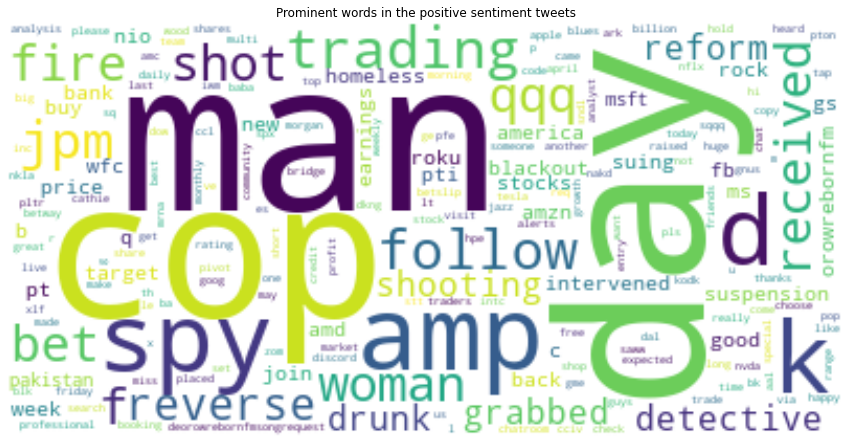

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot  as plt
wordCloud = WordCloud(background_color='white').generate_from_frequencies(frequency_of_words)

plt.figure(figsize=(15,10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title("Prominent words in the positive sentiment tweets")
plt.show()

In [45]:
#Positive sentiment tweets with respect to Tesla

words_list_positive = []
stop_words = StopWordsRemover.loadDefaultStopWords("english")
stop_words.remove("not")
stocks_code = ['lmnd','zm','okta','fvrr','flgt','tsla','aapl','bac']
for tweet in analysed_tweets.filter(analysed_tweets["prediction"]==1).filter(analysed_tweets["stock"]=="TSLA").select("cleaned_tweet").collect():
    if len(tweet["cleaned_tweet"].split())>0:
        for word in tweet["cleaned_tweet"].split():
            word=word.lower()
            if (str(word) not in stop_words) and (str(word) not in stocks_code):
                
                words_list_positive.append(word)

In [46]:
len(words_list_positive)

45604

In [47]:
frequency_of_words = nltk.FreqDist(words_list_positive)

In [48]:
frequency_of_words.most_common(30)

[('q', 708),
 ('tesla', 670),
 ('price', 495),
 ('target', 494),
 ('pt', 486),
 ('k', 471),
 ('amp', 425),
 ('spy', 382),
 ('buy', 339),
 ('ark', 325),
 ('qqq', 318),
 ('cathie', 307),
 ('wood', 301),
 ('new', 294),
 ('rating', 282),
 ('shares', 271),
 ('trading', 259),
 ('day', 248),
 ('market', 243),
 ('analyst', 243),
 ('gme', 232),
 ('profit', 226),
 ('hold', 225),
 ('f', 212),
 ('raised', 205),
 ('best', 195),
 ('today', 189),
 ('growth', 178),
 ('earnings', 178),
 ('pre', 171)]

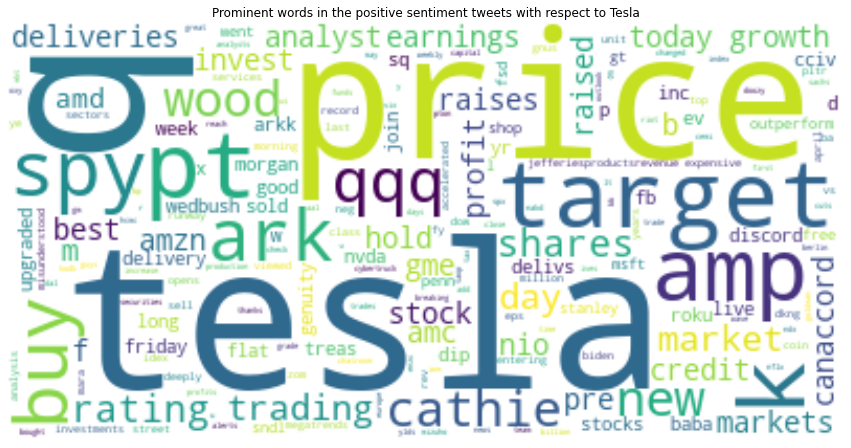

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot  as plt
wordCloud = WordCloud(background_color='white').generate_from_frequencies(frequency_of_words)

plt.figure(figsize=(15,10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title("Prominent words in the positive sentiment tweets with respect to Tesla")
plt.show()

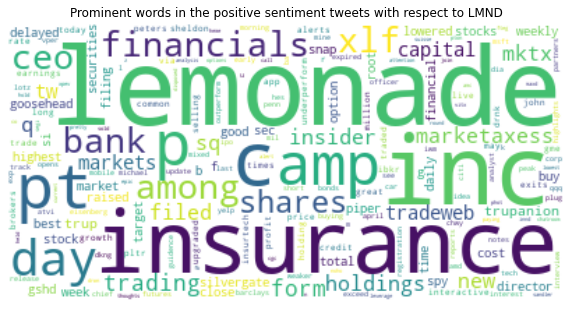

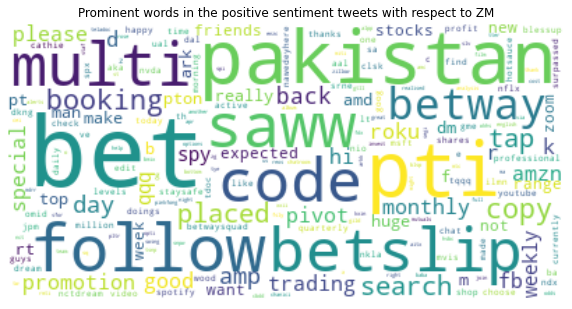

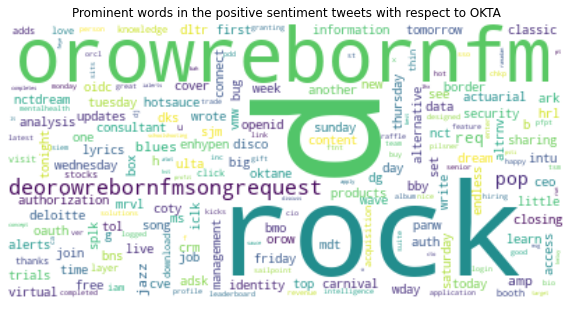

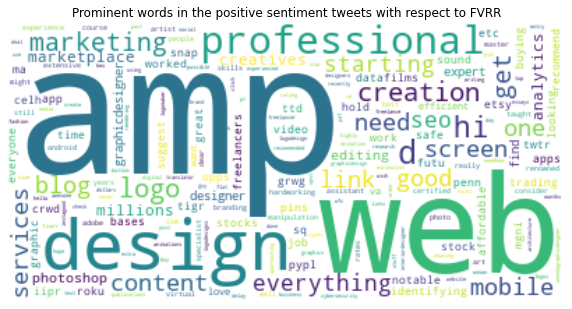

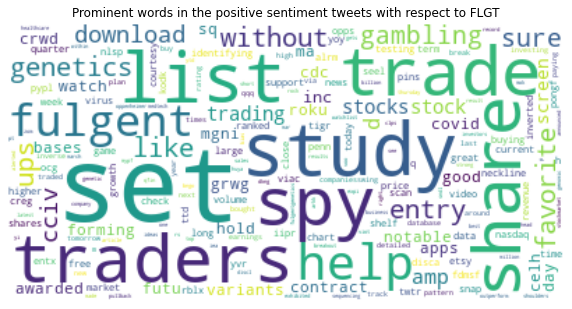

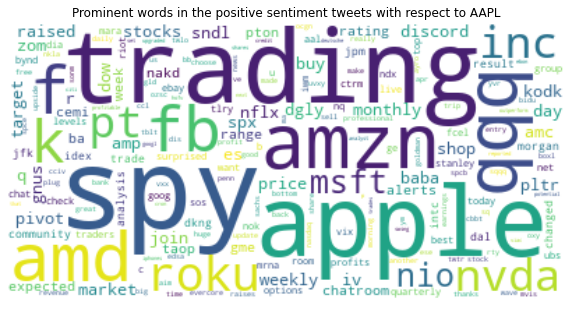

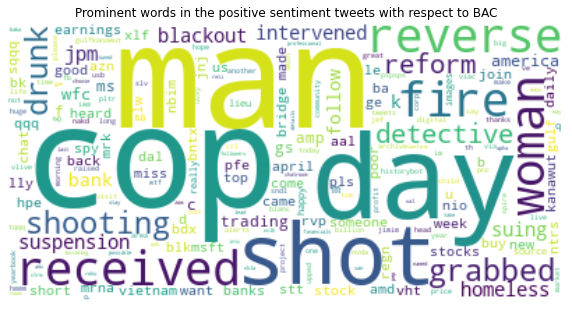

In [50]:
#Positive Tweets for each stock
stop_words = StopWordsRemover.loadDefaultStopWords("english")
stop_words.remove("not")
stocks_code = ['lmnd','zm','okta','fvrr','flgt','tsla','aapl','bac']
for stock in ['LMND','ZM','OKTA','FVRR','FLGT','AAPL','BAC'] :
    words_list_positive = []


    for tweet in analysed_tweets.filter(analysed_tweets["prediction"]==1).filter(analysed_tweets["stock"]==stock).select("cleaned_tweet").collect():
        if len(tweet["cleaned_tweet"].split())>0:
            for word in tweet["cleaned_tweet"].split():
                word=word.lower()
                if (str(word) not in stop_words) and (str(word) not in stocks_code):
                
                    words_list_positive.append(word)
    
    frequency_of_words = nltk.FreqDist(words_list_positive)
    
    wordCloud = WordCloud(background_color='white').generate_from_frequencies(frequency_of_words)

    plt.figure(figsize=(10,8))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    title = "Prominent words in the positive sentiment tweets with respect to " + stock
    plt.title( title)
    plt.show()

In [51]:
#Negative sentiment tweets

words_list_negative = []
stop_words = StopWordsRemover.loadDefaultStopWords("english")
stop_words.remove("not")
stocks_code = ['lmnd','zm','okta','fvrr','flgt','tsla','aapl','bac']

for tweet in analysed_tweets.filter(analysed_tweets["prediction"]==0).select("cleaned_tweet").collect():
    if len(tweet["cleaned_tweet"].split())>0:
        for word in tweet["cleaned_tweet"].split():
            word=word.lower()
            if (str(word) not in stop_words) and (str(word) not in stocks_code):
                
                words_list_negative.append(word)

In [52]:
len(words_list_negative)

2882154

In [53]:
frequency_of_words = nltk.FreqDist(words_list_negative)

In [54]:
frequency_of_words.most_common(30)

[('amzn', 21354),
 ('fb', 20963),
 ('spy', 18046),
 ('msft', 16246),
 ('amp', 14862),
 ('nio', 14008),
 ('stocks', 13814),
 ('tesla', 13796),
 ('amd', 12163),
 ('not', 11768),
 ('m', 11611),
 ('like', 11238),
 ('nvda', 11150),
 ('get', 10841),
 ('gme', 10246),
 ('amc', 10127),
 ('nflx', 10123),
 ('ba', 10072),
 ('qqq', 10052),
 ('sq', 9524),
 ('pltr', 9521),
 ('roku', 9391),
 ('today', 9211),
 ('stock', 8950),
 ('week', 8523),
 ('baba', 8340),
 ('call', 8228),
 ('new', 8216),
 ('shop', 8190),
 ('one', 8185)]

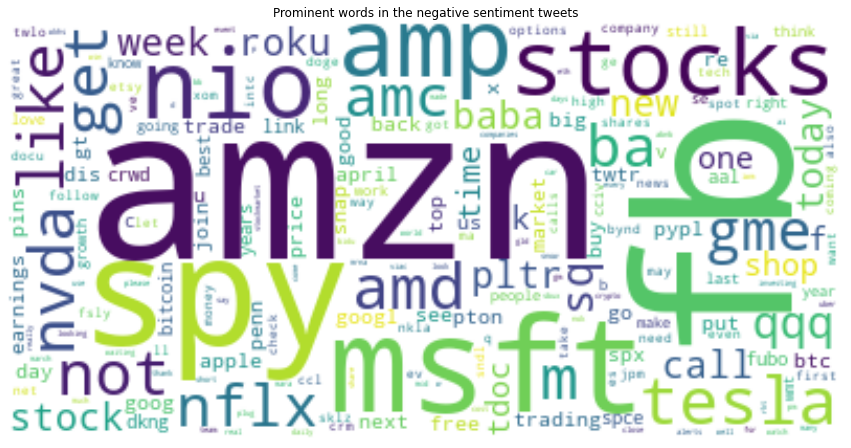

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot  as plt
wordCloud = WordCloud(background_color='white').generate_from_frequencies(frequency_of_words)

plt.figure(figsize=(15,10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title("Prominent words in the negative sentiment tweets")
plt.show()

In [56]:
#Negative sentiment tweets wrt to tesla

words_list_negative = []
stop_words = StopWordsRemover.loadDefaultStopWords("english")
stop_words.remove("not")
stocks_code = ['lmnd','zm','okta','fvrr','flgt','tsla','aapl','bac']

for tweet in analysed_tweets.filter(analysed_tweets["prediction"]==0).filter(analysed_tweets["stock"]=="TSLA").select("cleaned_tweet").collect():
    if len(tweet["cleaned_tweet"].split())>0:
        for word in tweet["cleaned_tweet"].split():
            word=word.lower()
            if (str(word) not in stop_words) and (str(word) not in stocks_code):
                
                words_list_negative.append(word)

In [57]:
len(words_list_negative)

677474

In [58]:
frequency_of_words = nltk.FreqDist(words_list_negative)

In [59]:
frequency_of_words.most_common(30)

[('tesla', 12180),
 ('stocks', 3954),
 ('not', 3863),
 ('nio', 3859),
 ('amp', 3844),
 ('amzn', 3366),
 ('spy', 3336),
 ('gme', 3235),
 ('stock', 3129),
 ('btc', 2984),
 ('bitcoin', 2863),
 ('fb', 2836),
 ('m', 2621),
 ('like', 2509),
 ('amc', 2505),
 ('market', 2495),
 ('shares', 2394),
 ('today', 2286),
 ('ev', 2284),
 ('k', 2284),
 ('msft', 2258),
 ('price', 2149),
 ('april', 2123),
 ('buy', 2103),
 ('get', 2057),
 ('next', 2006),
 ('elon', 2003),
 ('one', 1987),
 ('week', 1929),
 ('new', 1914)]

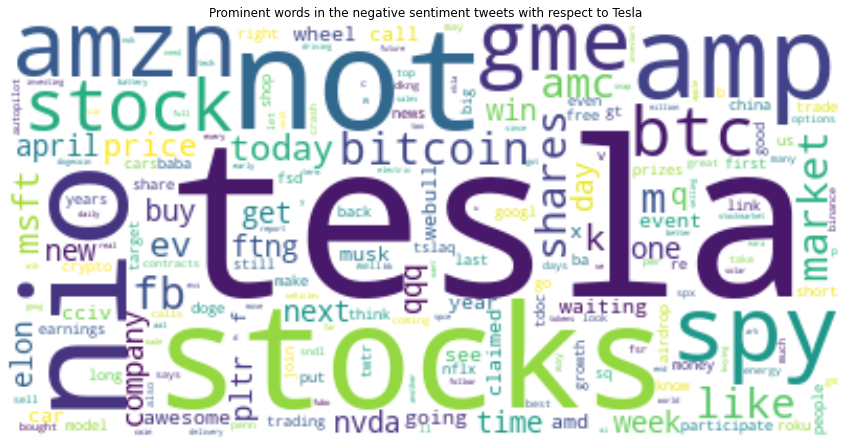

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot  as plt
wordCloud = WordCloud(background_color='white').generate_from_frequencies(frequency_of_words)

plt.figure(figsize=(15,10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title("Prominent words in the negative sentiment tweets with respect to Tesla")
plt.show()

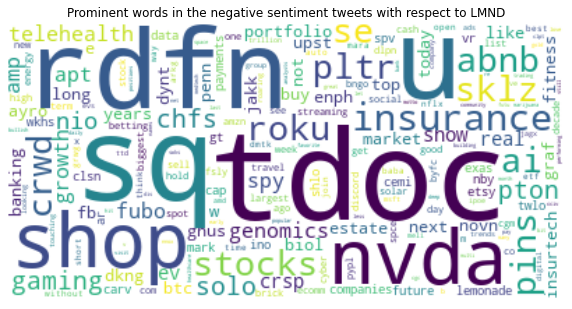

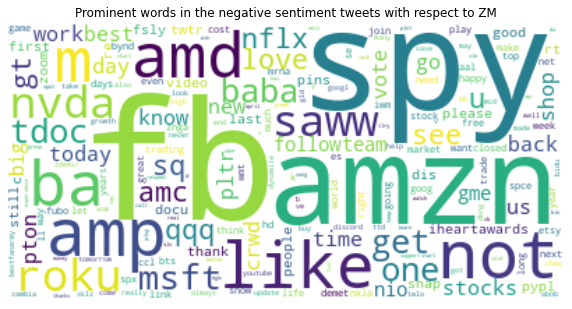

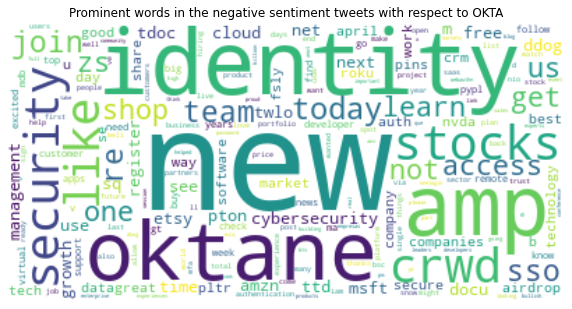

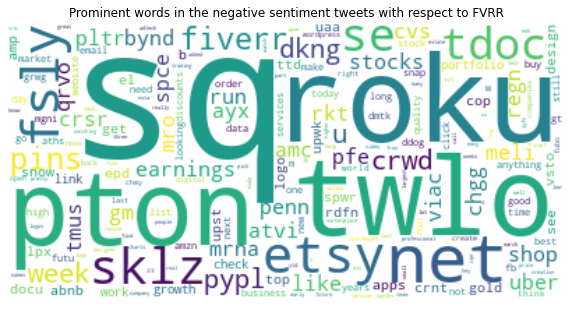

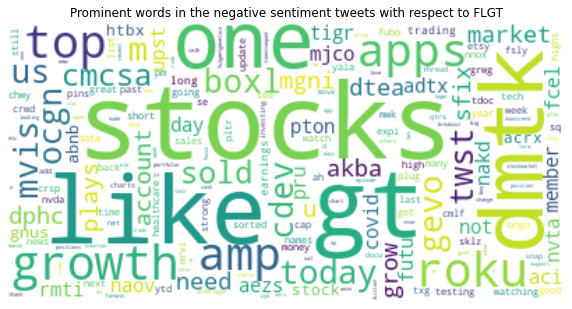

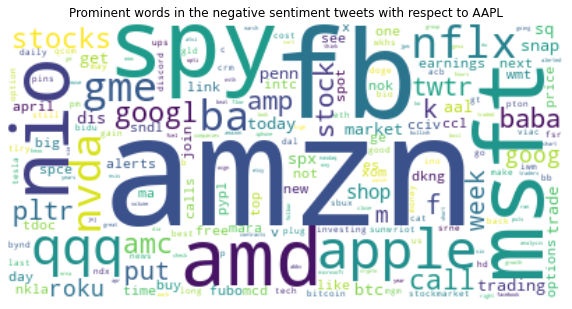

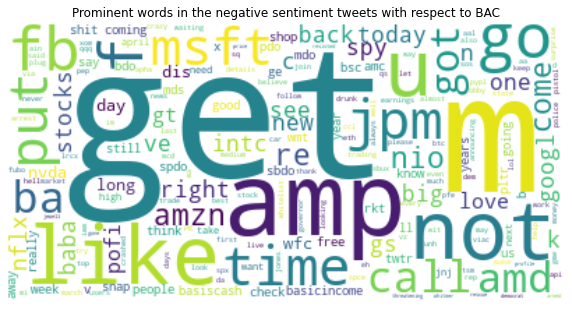

In [61]:
#Negative Tweets for each stock
stop_words = StopWordsRemover.loadDefaultStopWords("english")
stop_words.remove("not")
stocks_code = ['lmnd','zm','okta','fvrr','flgt','tsla','aapl','bac']
for stock in ['LMND','ZM','OKTA','FVRR','FLGT','AAPL','BAC'] :
    words_list_positive = []


    for tweet in analysed_tweets.filter(analysed_tweets["prediction"]==0).filter(analysed_tweets["stock"]==stock).select("cleaned_tweet").collect():
        if len(tweet["cleaned_tweet"].split())>0:
            for word in tweet["cleaned_tweet"].split():
                word=word.lower()
                if (str(word) not in stop_words) and (str(word) not in stocks_code):
                
                    words_list_positive.append(word)
    
    frequency_of_words = nltk.FreqDist(words_list_positive)
    
    wordCloud = WordCloud(background_color='white').generate_from_frequencies(frequency_of_words)

    plt.figure(figsize=(10,8))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    title = "Prominent words in the negative sentiment tweets with respect to " + stock
    plt.title( title)
    plt.show()

## Feature extraction for stock price prediction model

## Analysing the stocks sentiment percentage on each day

In [62]:
stocks_values =analysed_tweets.select("stock").distinct().collect()
stocks_list = []

for x in stocks_values:
    stocks_list.append(x["stock"])
    

In [63]:
stocks_list

['LMND', 'ZM', 'OKTA', 'AAPL', 'TSLA', 'FVRR', 'BAC', 'FLGT']

In [64]:
analysed_tweets.filter(analysed_tweets.created_date=="2021-04-17").groupby("stock").count().show()

+-----+-----+
|stock|count|
+-----+-----+
| LMND|   29|
|   ZM|  466|
| OKTA|   64|
| FVRR|    9|
| FLGT|    4|
+-----+-----+



#### NOTE:

For April 17, we could not collect tweets for all the stocks due to technical glitches.

In [65]:
dates_temp = dates_list.copy()
dates_temp.remove("2021-04-17")

positive_sentiment_percentage = []
for date in dates_temp: #for now, check later
    for stock in  stocks_list:
        temp_pos = analysed_tweets.filter(analysed_tweets["dates"]==date).filter(analysed_tweets["stock"]==stock).filter(analysed_tweets["prediction"]==1).count()
        temp_all = analysed_tweets.filter(analysed_tweets["dates"]==date).filter(analysed_tweets["stock"]==stock).count()        
        positive_perc = (temp_pos/temp_all)
        positive_sentiment_percentage.append((date,stock,positive_perc))

In [66]:
#analysed_tweets.filter(analysed_tweets.prediction==1).groupby("dates","stock").count().show()

In [67]:
positive_sentiment_percentage

[('2021-03-12', 'LMND', 0.10434782608695652),
 ('2021-03-12', 'ZM', 0.10123734533183353),
 ('2021-03-12', 'OKTA', 0.06779661016949153),
 ('2021-03-12', 'AAPL', 0.07078651685393259),
 ('2021-03-12', 'TSLA', 0.04044943820224719),
 ('2021-03-12', 'FVRR', 0.0),
 ('2021-03-12', 'BAC', 0.23873873873873874),
 ('2021-03-12', 'FLGT', 0.1935483870967742),
 ('2021-03-13', 'LMND', 0.06578947368421052),
 ('2021-03-13', 'ZM', 0.10112359550561797),
 ('2021-03-13', 'OKTA', 0.25925925925925924),
 ('2021-03-13', 'AAPL', 0.060714285714285714),
 ('2021-03-13', 'TSLA', 0.033707865168539325),
 ('2021-03-13', 'FVRR', 0.0449438202247191),
 ('2021-03-13', 'BAC', 0.25862068965517243),
 ('2021-03-13', 'FLGT', 0.1794871794871795),
 ('2021-03-14', 'LMND', 0.26126126126126126),
 ('2021-03-14', 'ZM', 0.06853932584269663),
 ('2021-03-14', 'OKTA', 0.18098159509202455),
 ('2021-03-14', 'AAPL', 0.048314606741573035),
 ('2021-03-14', 'TSLA', 0.02247191011235955),
 ('2021-03-14', 'FVRR', 0.010101010101010102),
 ('2021-03-

In [68]:
schema = StructType([\
    StructField("date",StringType(),False), \
    StructField("stock_name",StringType(),False), \
    StructField("positive_sentiment", FloatType(), False) \
  ])
 
sentiments_data = spark.createDataFrame(data=positive_sentiment_percentage,schema=schema)


In [69]:
sentiments_data.show()

+----------+----------+------------------+
|      date|stock_name|positive_sentiment|
+----------+----------+------------------+
|2021-03-12|      LMND|       0.104347825|
|2021-03-12|        ZM|        0.10123734|
|2021-03-12|      OKTA|        0.06779661|
|2021-03-12|      AAPL|        0.07078651|
|2021-03-12|      TSLA|       0.040449437|
|2021-03-12|      FVRR|               0.0|
|2021-03-12|       BAC|        0.23873875|
|2021-03-12|      FLGT|        0.19354838|
|2021-03-13|      LMND|       0.065789476|
|2021-03-13|        ZM|       0.101123594|
|2021-03-13|      OKTA|        0.25925925|
|2021-03-13|      AAPL|       0.060714286|
|2021-03-13|      TSLA|       0.033707865|
|2021-03-13|      FVRR|        0.04494382|
|2021-03-13|       BAC|        0.25862068|
|2021-03-13|      FLGT|        0.17948718|
|2021-03-14|      LMND|        0.26126125|
|2021-03-14|        ZM|        0.06853933|
|2021-03-14|      OKTA|        0.18098159|
|2021-03-14|      AAPL|       0.048314605|
+----------

In [70]:
#ref: https://dwgeek.com/replace-pyspark-dataframe-column-value-methods.html/#:~:text=Replace%20Spark%20DataFrame%20Column%20Value,replaces%20%E2%80%9Ca%E2%80%9D%20with%20zero.&text=The%20function%20withColumn%20replaces%20column,name%20exists%20in%20data%20frame.
temp_sent = sentiments_data.filter(sentiments_data.date=="2021-04-16")
temp_sent = temp_sent.withColumn("date", regexp_replace("date",'2021-04-16','2021-04-17'))
temp_sent.show()

+----------+----------+------------------+
|      date|stock_name|positive_sentiment|
+----------+----------+------------------+
|2021-04-17|      LMND|       0.023255814|
|2021-04-17|        ZM|        0.06516854|
|2021-04-17|      OKTA|       0.065743946|
|2021-04-17|      AAPL|       0.049199086|
|2021-04-17|      TSLA|       0.035897437|
|2021-04-17|      FVRR|       0.011764706|
|2021-04-17|       BAC|         0.8859447|
|2021-04-17|      FLGT|        0.32352942|
+----------+----------+------------------+



In [71]:
sentiments_data = sentiments_data.union(temp_sent)

In [72]:
#confirming that all the dates are present
sentiments_data.select("date").distinct().sort("date").show(100)

+----------+
|      date|
+----------+
|2021-03-12|
|2021-03-13|
|2021-03-14|
|2021-03-15|
|2021-03-16|
|2021-03-17|
|2021-03-18|
|2021-03-19|
|2021-03-20|
|2021-03-21|
|2021-03-22|
|2021-03-23|
|2021-03-24|
|2021-03-25|
|2021-03-26|
|2021-03-27|
|2021-03-28|
|2021-03-29|
|2021-03-30|
|2021-03-31|
|2021-04-01|
|2021-04-02|
|2021-04-03|
|2021-04-04|
|2021-04-05|
|2021-04-06|
|2021-04-07|
|2021-04-08|
|2021-04-09|
|2021-04-10|
|2021-04-11|
|2021-04-12|
|2021-04-13|
|2021-04-14|
|2021-04-15|
|2021-04-16|
|2021-04-17|
|2021-04-18|
|2021-04-19|
|2021-04-20|
|2021-04-21|
|2021-04-22|
|2021-04-23|
|2021-04-24|
|2021-04-25|
|2021-04-26|
|2021-04-27|
|2021-04-28|
|2021-04-29|
|2021-04-30|
|2021-05-01|
|2021-05-02|
|2021-05-03|
|2021-05-04|
|2021-05-05|
+----------+



In [73]:
sentiments_data = sentiments_data.withColumn("positive_sentiment_rounded", round(sentiments_data.positive_sentiment,2))
sentiments_data.show()

+----------+----------+------------------+--------------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|
+----------+----------+------------------+--------------------------+
|2021-03-12|      LMND|       0.104347825|                       0.1|
|2021-03-12|        ZM|        0.10123734|                       0.1|
|2021-03-12|      OKTA|        0.06779661|                      0.07|
|2021-03-12|      AAPL|        0.07078651|                      0.07|
|2021-03-12|      TSLA|       0.040449437|                      0.04|
|2021-03-12|      FVRR|               0.0|                       0.0|
|2021-03-12|       BAC|        0.23873875|                      0.24|
|2021-03-12|      FLGT|        0.19354838|                      0.19|
|2021-03-13|      LMND|       0.065789476|                      0.07|
|2021-03-13|        ZM|       0.101123594|                       0.1|
|2021-03-13|      OKTA|        0.25925925|                      0.26|
|2021-03-13|      AA

## Collecting the closing price of each stock since March 12

In [74]:
#Collected stock_tweets since march 12

#ref: https://eodhistoricaldata.com/financial-apis/api-for-historical-data-and-volumes/

import requests

stocks_closing_price = []

for stock in stocks_list:
    url = "https://eodhistoricaldata.com/api/eod/" + stock+".US?from=2021-03-12&to=2021-05-05&api_token=606a4317aa69b0.79843694&period=d&fmt=json"

    r = requests.get(url)
    
    for i in range(len(r.json())):
        temp = r.json()
        stocks_closing_price.append((temp[i]["date"], stock, float(temp[i]["close"])))


In [75]:
type(stocks_closing_price[0][2])

float

In [76]:
schema = StructType([\
    StructField("date",StringType(),False), \
    StructField("stock_name",StringType(),False), \
    StructField("closing_price", FloatType(), False) \
  ])
 
stocks_closing_price_data = spark.createDataFrame(data=stocks_closing_price,schema=schema)


In [77]:
stocks_closing_price_data.show()

+----------+----------+-------------+
|      date|stock_name|closing_price|
+----------+----------+-------------+
|2021-03-12|      LMND|       104.54|
|2021-03-15|      LMND|       109.98|
|2021-03-16|      LMND|       107.33|
|2021-03-17|      LMND|       104.77|
|2021-03-18|      LMND|        96.25|
|2021-03-19|      LMND|         99.7|
|2021-03-22|      LMND|         98.6|
|2021-03-23|      LMND|        95.88|
|2021-03-24|      LMND|        89.28|
|2021-03-25|      LMND|        88.99|
|2021-03-26|      LMND|        87.38|
|2021-03-29|      LMND|        83.61|
|2021-03-30|      LMND|        89.86|
|2021-03-31|      LMND|        93.13|
|2021-04-01|      LMND|        95.58|
|2021-04-05|      LMND|        92.05|
|2021-04-06|      LMND|         95.2|
|2021-04-07|      LMND|        91.66|
|2021-04-08|      LMND|         95.0|
|2021-04-09|      LMND|        92.69|
+----------+----------+-------------+
only showing top 20 rows



In [78]:
#ref:https://sparkbyexamples.com/pyspark/pyspark-orderby-and-sort-explained/
#ref: https://stackoverflow.com/questions/38063657/pyspark-merge-outer-join-two-data-frames
sentiment_closing_price_data = sentiments_data.join(stocks_closing_price_data,on=["date","stock_name"],how="left").orderBy("date","stock_name")
sentiment_closing_price_data.show()

+----------+----------+------------------+--------------------------+-------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|
+----------+----------+------------------+--------------------------+-------------+
|2021-03-12|      AAPL|        0.07078651|                      0.07|       121.03|
|2021-03-12|       BAC|        0.23873875|                      0.24|        37.94|
|2021-03-12|      FLGT|        0.19354838|                      0.19|         95.6|
|2021-03-12|      FVRR|               0.0|                       0.0|       243.88|
|2021-03-12|      LMND|       0.104347825|                       0.1|       104.54|
|2021-03-12|      OKTA|        0.06779661|                      0.07|        227.0|
|2021-03-12|      TSLA|       0.040449437|                      0.04|       693.73|
|2021-03-12|        ZM|        0.10123734|                       0.1|       346.39|
|2021-03-13|      AAPL|       0.060714286|                      0.06|       

In [79]:
sentiment_closing_price_data.printSchema()

root
 |-- date: string (nullable = false)
 |-- stock_name: string (nullable = false)
 |-- positive_sentiment: float (nullable = false)
 |-- positive_sentiment_rounded: float (nullable = true)
 |-- closing_price: float (nullable = true)



In [80]:
sentiment_closing_price_data.sort("stock_name","date").show()

+----------+----------+------------------+--------------------------+-------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|
+----------+----------+------------------+--------------------------+-------------+
|2021-03-12|      AAPL|        0.07078651|                      0.07|       121.03|
|2021-03-13|      AAPL|       0.060714286|                      0.06|         null|
|2021-03-14|      AAPL|       0.048314605|                      0.05|         null|
|2021-03-15|      AAPL|       0.062921345|                      0.06|       123.99|
|2021-03-16|      AAPL|         0.1489842|                      0.15|       125.57|
|2021-03-17|      AAPL|       0.050847456|                      0.05|       124.76|
|2021-03-18|      AAPL|       0.020869566|                      0.02|       120.53|
|2021-03-19|      AAPL|       0.031496063|                      0.03|       119.99|
|2021-03-20|      AAPL|       0.031609196|                      0.03|       

In [81]:
sentiment_closing_price_pd_df = sentiment_closing_price_data.toPandas()

In [82]:
sentiment_closing_price_pd_df.head()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
0  2021-03-12       AAPL            0.070787                        0.07   
1  2021-03-12        BAC            0.238739                        0.24   
2  2021-03-12       FLGT            0.193548                        0.19   
3  2021-03-12       FVRR            0.000000                        0.00   
4  2021-03-12       LMND            0.104348                        0.10   

   closing_price  
0     121.029999  
1      37.939999  
2      95.599998  
3     243.880005  
4     104.540001

In [83]:
sentiment_closing_price_pd_df["positive_sentiment_percentage"] = sentiment_closing_price_pd_df["positive_sentiment_rounded"]*100

In [84]:
sentiment_closing_price_pd_df.isnull().sum()

date                               0
stock_name                         0
positive_sentiment                 0
positive_sentiment_rounded         0
closing_price                    136
positive_sentiment_percentage      0
dtype: int64

As during weekends the stock market does not function, there is no closing price for those days.

However, as the closing price on weekends is same as Friday, I am going to fill those null values with previous days stock's closing price

In [85]:
sentiment_closing_price_pd_df = sentiment_closing_price_pd_df.sort_values(["stock_name","date"]).fillna(method="ffill").copy()
sentiment_closing_price_pd_df

date stock_name  positive_sentiment  positive_sentiment_rounded  \
0    2021-03-12       AAPL            0.070787                        0.07   
8    2021-03-13       AAPL            0.060714                        0.06   
16   2021-03-14       AAPL            0.048315                        0.05   
24   2021-03-15       AAPL            0.062921                        0.06   
32   2021-03-16       AAPL            0.148984                        0.15   
..          ...        ...                 ...                         ...   
407  2021-05-01         ZM            0.095506                        0.10   
415  2021-05-02         ZM            0.122549                        0.12   
423  2021-05-03         ZM            0.057303                        0.06   
431  2021-05-04         ZM            0.218223                        0.22   
439  2021-05-05         ZM            0.085393                        0.09   

     closing_price  positive_sentiment_percentage  
0       121.029999                       7.000000  
8       121.029999                       6.000000  
16      121.029999                       5.000000  
24      123.989998                       6.000000  
32      125.570000                      15.000001  
..             ...                            ...  
407     319.570007                      10.000000  
415     319.570007                      12.000000  
423     313.920013                       6.000000  
431     304.850006                      22.000000  
439     297.589996                       9.000000  

[440 rows x 6 columns]

In [86]:
#Ensuring that there are no more missing vlaues
sentiment_closing_price_pd_df.isnull().sum()

date                             0
stock_name                       0
positive_sentiment               0
positive_sentiment_rounded       0
closing_price                    0
positive_sentiment_percentage    0
dtype: int64

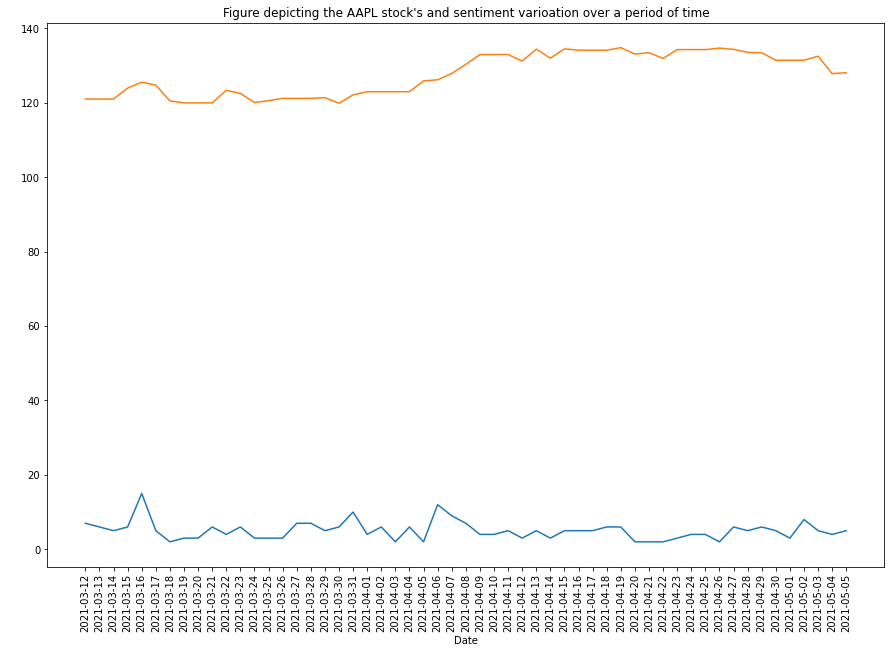

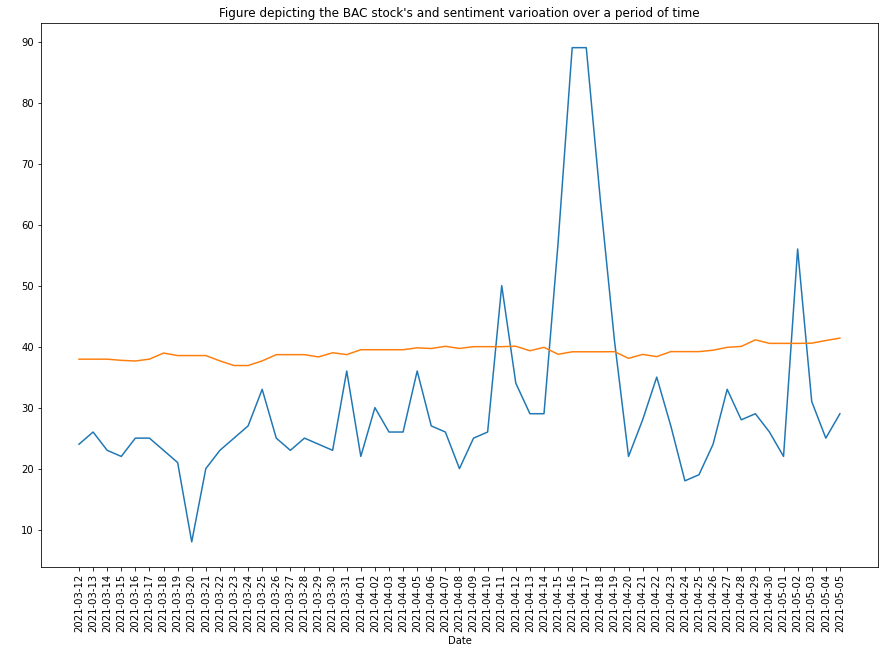

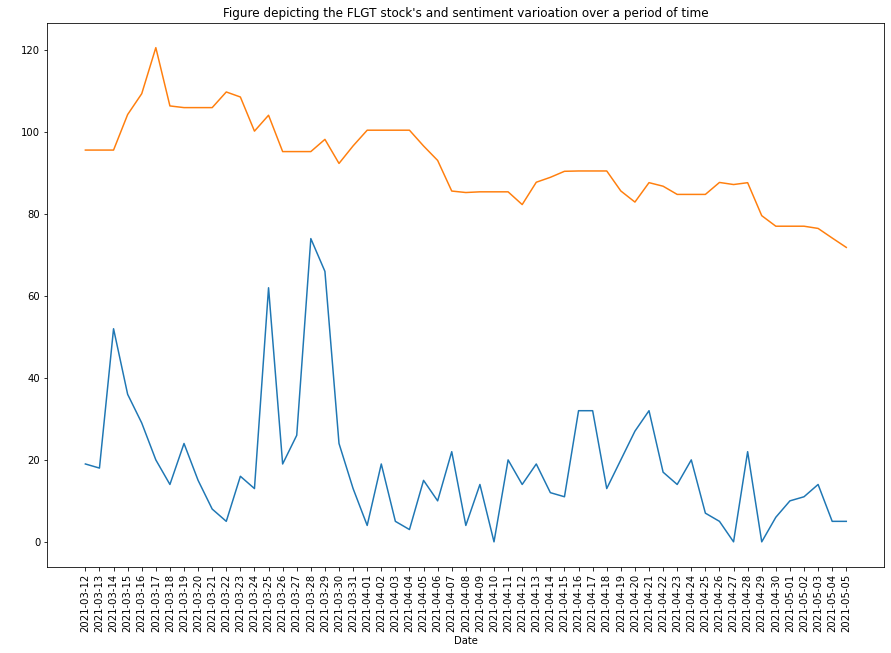

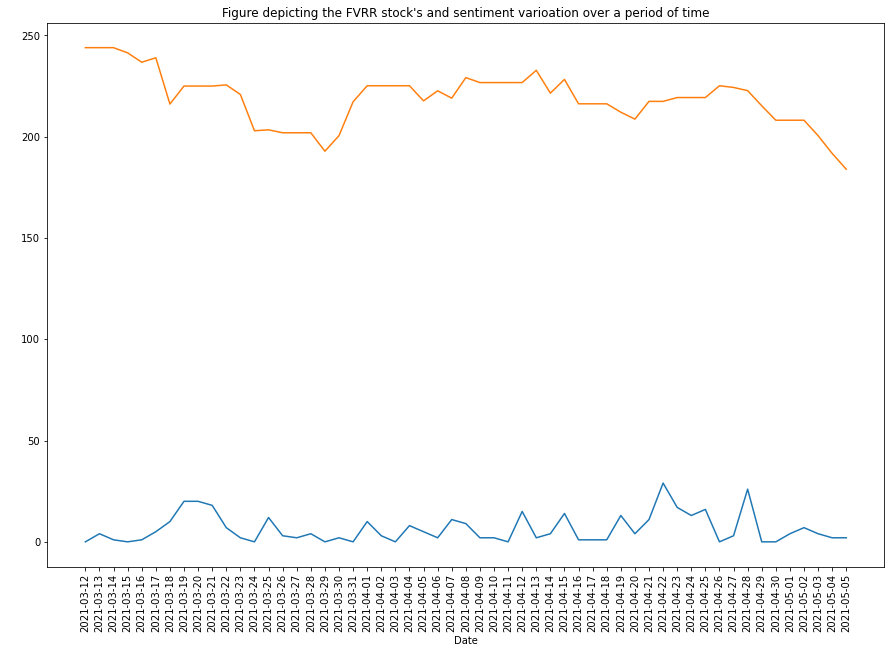

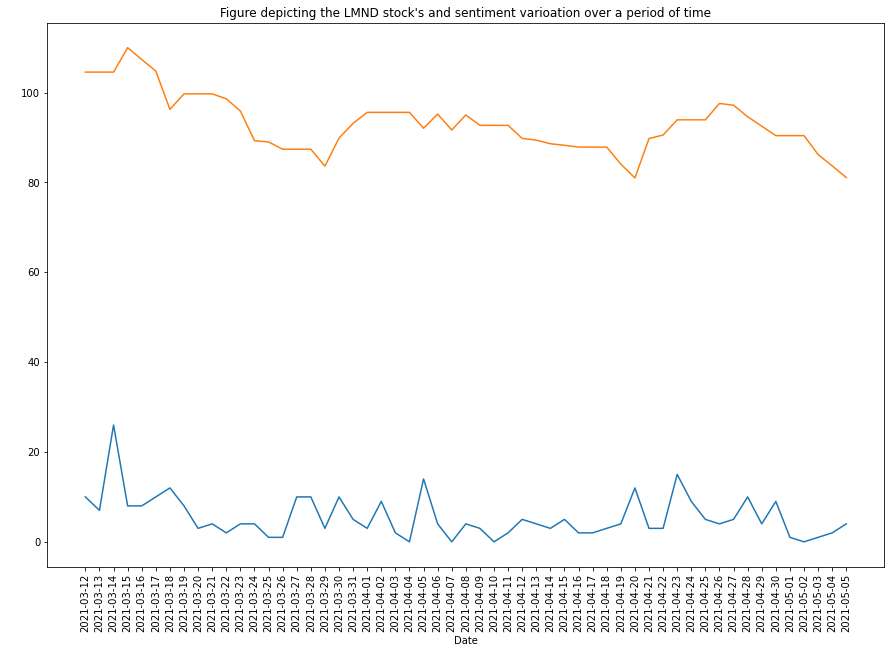

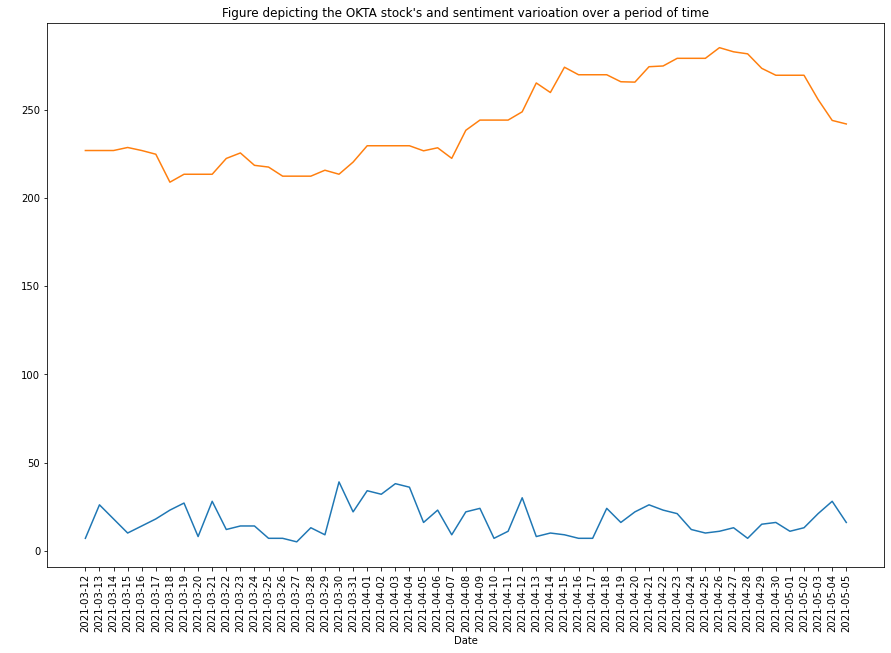

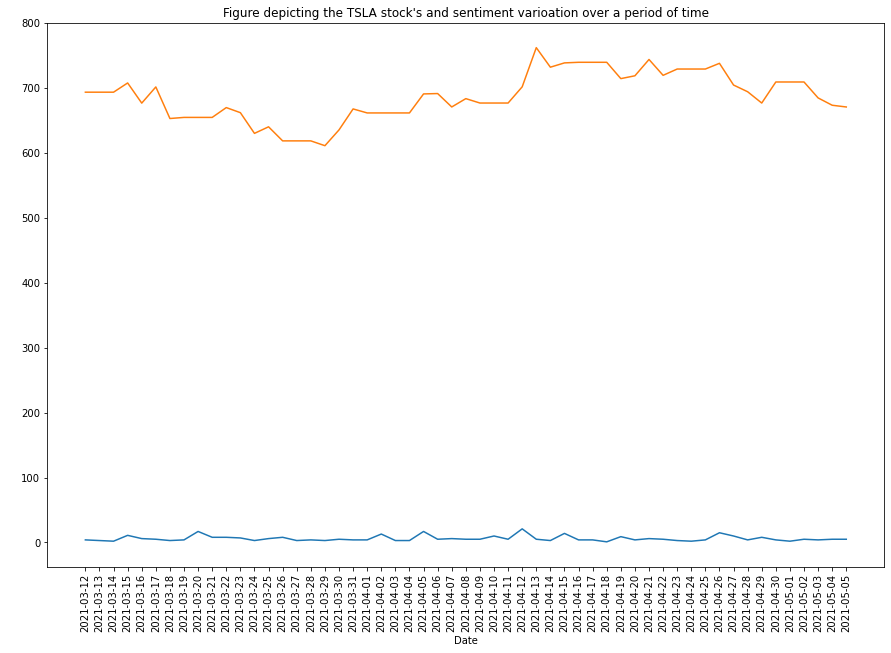

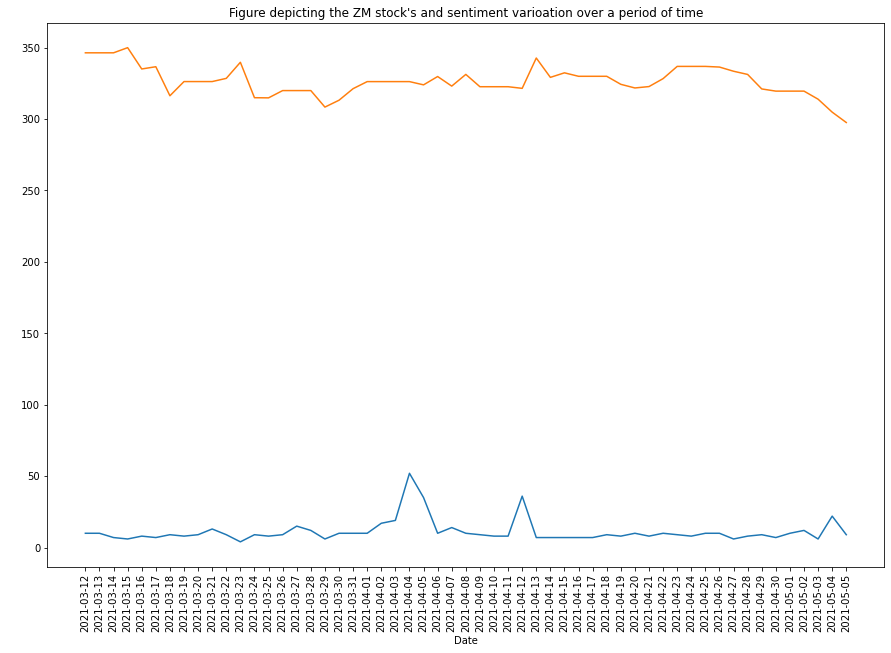

In [87]:
for stock in sentiment_closing_price_pd_df["stock_name"].unique():
        
    plt.figure(figsize=(15,10))
    sns.lineplot(data=sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]==stock], x="date",y="positive_sentiment_percentage")
    sns.lineplot(data=sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]==stock], x="date",y="closing_price")
    plt.title("Figure depicting the "+stock+" stock's and sentiment varioation over a period of time")
    plt.xticks(rotation=90)
    plt.ylabel(" ")
    plt.xlabel("Date")
    plt.show()

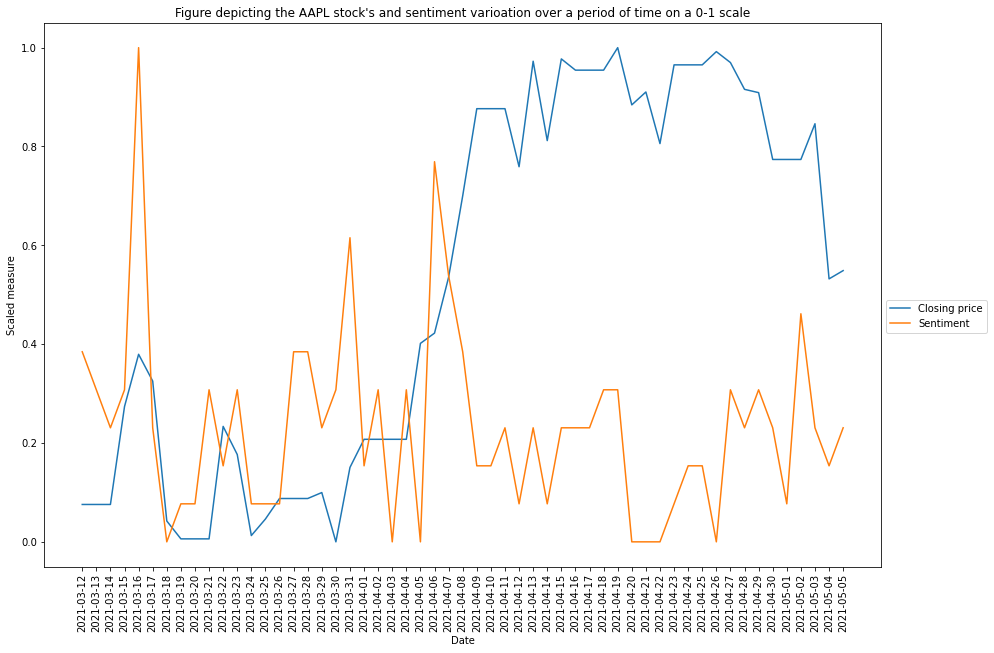

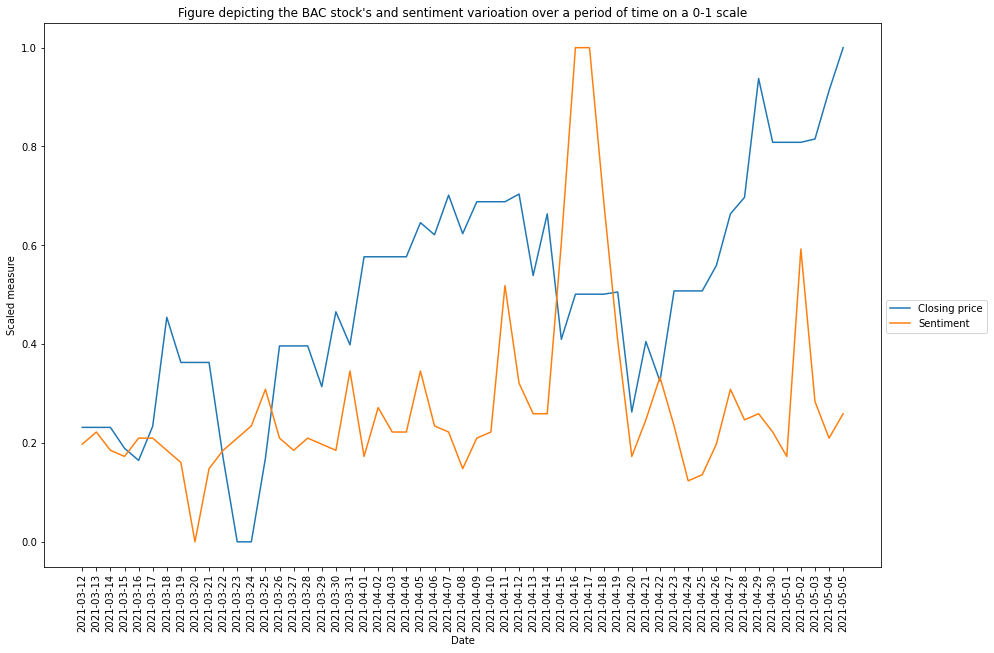

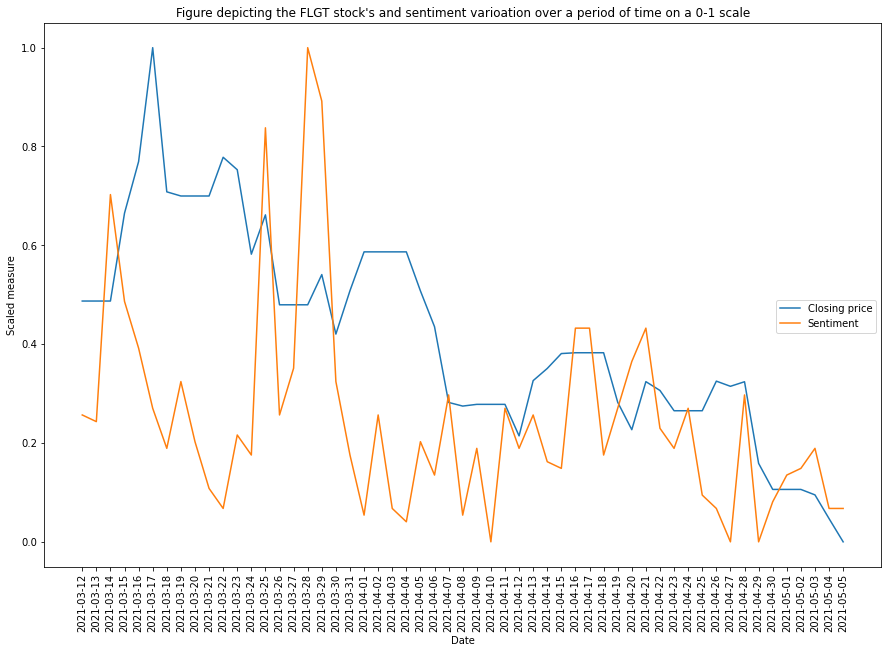

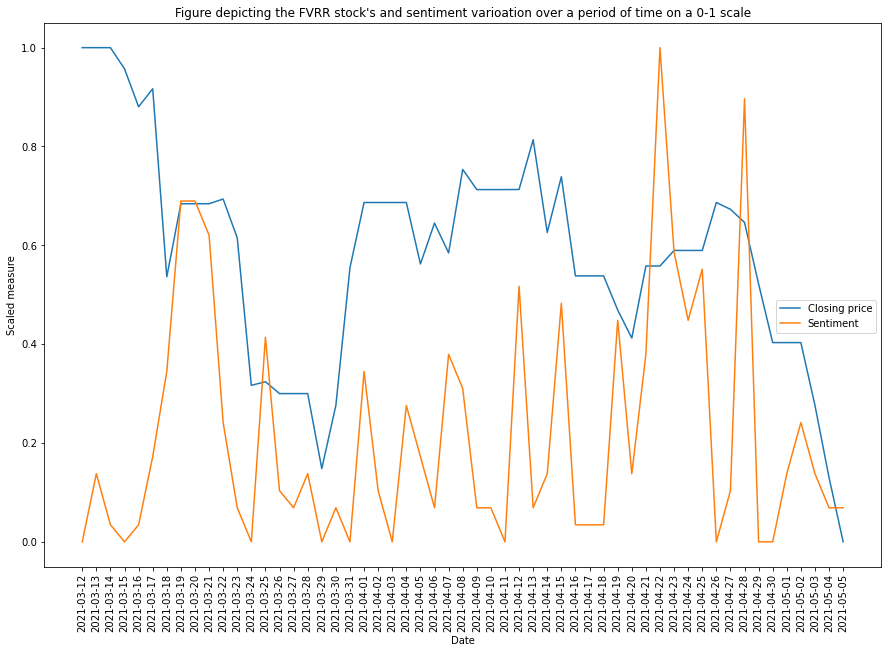

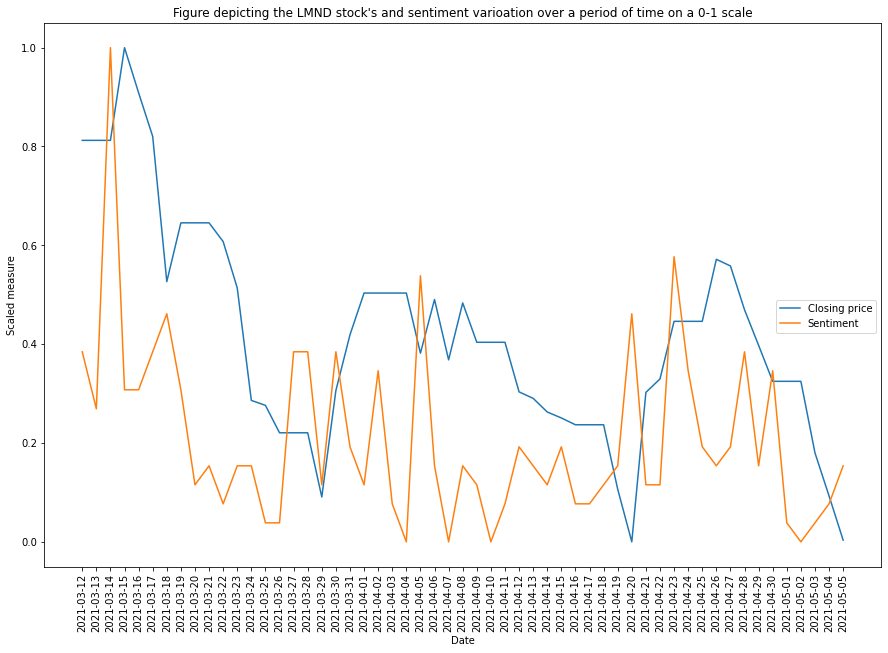

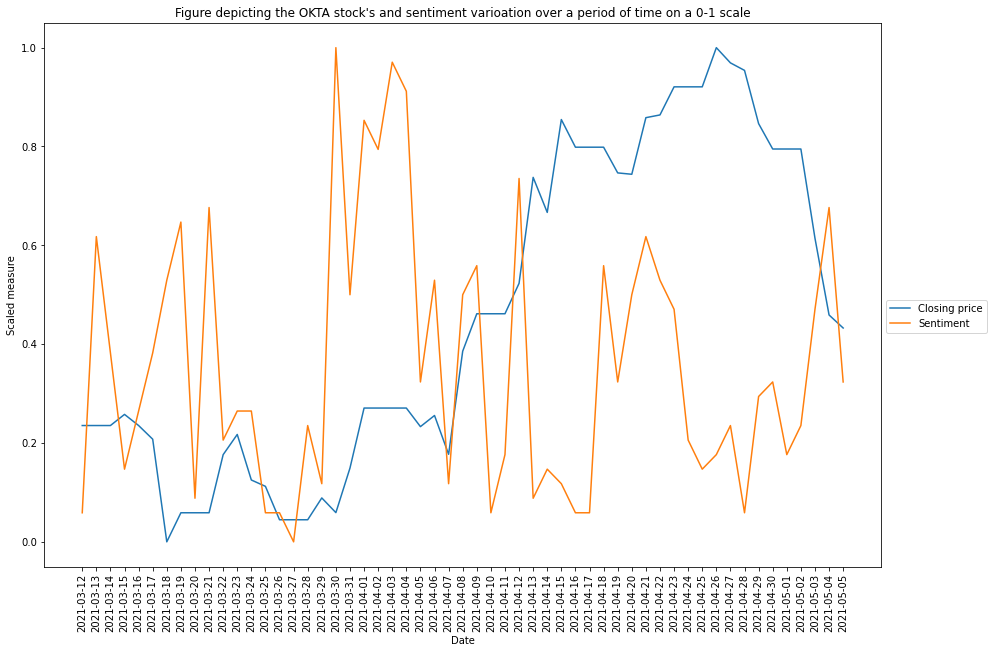

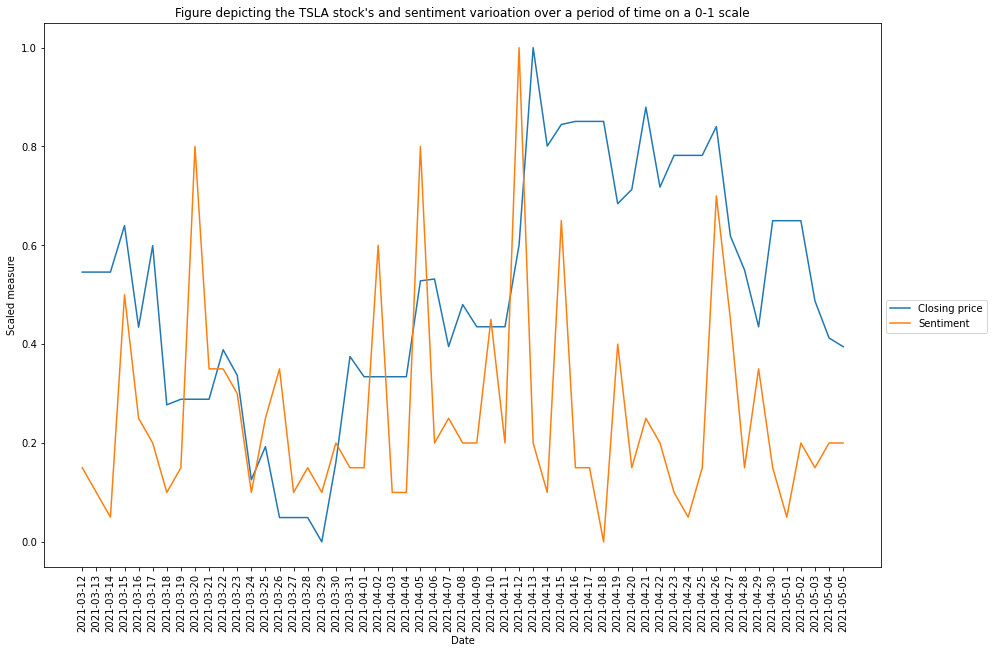

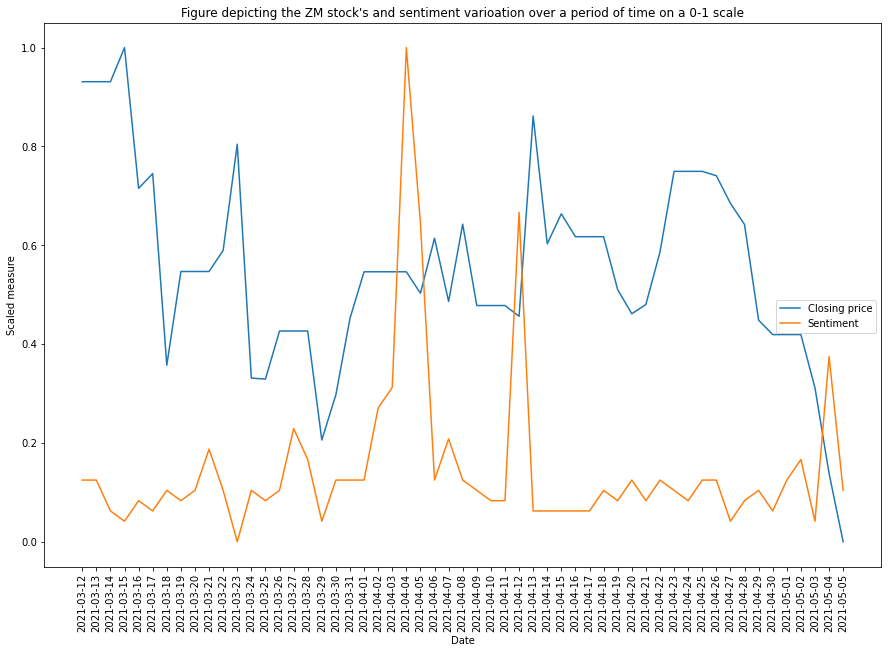

In [88]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
for stock in sentiment_closing_price_pd_df["stock_name"].unique():
    temp_data = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]==stock].copy()
    #temp_data = temp_data[~temp_data["closing_price"].isnull()]
    minmax = MinMaxScaler()

    temp_data["cp"] = minmax.fit_transform(np.array(temp_data["closing_price"]).reshape(-1,1))
    temp_data["ss"] = minmax.fit_transform(np.array(temp_data["positive_sentiment_rounded"]).reshape(-1,1))
    
    plt.figure(figsize=(15,10))
    sns.lineplot(data=temp_data, x="date",y="cp",label="Closing price")
    sns.lineplot(data=temp_data, x="date",y="ss",label="Sentiment")
    plt.title("Figure depicting the "+stock+" stock's and sentiment varioation over a period of time on a 0-1 scale")
    plt.legend(bbox_to_anchor=(1,0.5))
    plt.xticks(rotation=90)
    plt.xlabel("Date")
    plt.ylabel("Scaled measure")
    plt.show()

In [89]:
sentiment_closing_price_data.printSchema()

root
 |-- date: string (nullable = false)
 |-- stock_name: string (nullable = false)
 |-- positive_sentiment: float (nullable = false)
 |-- positive_sentiment_rounded: float (nullable = true)
 |-- closing_price: float (nullable = true)



In [90]:
sentiment_closing_price_pd_df

date stock_name  positive_sentiment  positive_sentiment_rounded  \
0    2021-03-12       AAPL            0.070787                        0.07   
8    2021-03-13       AAPL            0.060714                        0.06   
16   2021-03-14       AAPL            0.048315                        0.05   
24   2021-03-15       AAPL            0.062921                        0.06   
32   2021-03-16       AAPL            0.148984                        0.15   
..          ...        ...                 ...                         ...   
407  2021-05-01         ZM            0.095506                        0.10   
415  2021-05-02         ZM            0.122549                        0.12   
423  2021-05-03         ZM            0.057303                        0.06   
431  2021-05-04         ZM            0.218223                        0.22   
439  2021-05-05         ZM            0.085393                        0.09   

     closing_price  positive_sentiment_percentage  
0       121.029999                       7.000000  
8       121.029999                       6.000000  
16      121.029999                       5.000000  
24      123.989998                       6.000000  
32      125.570000                      15.000001  
..             ...                            ...  
407     319.570007                      10.000000  
415     319.570007                      12.000000  
423     313.920013                       6.000000  
431     304.850006                      22.000000  
439     297.589996                       9.000000  

[440 rows x 6 columns]

## Feature engineering for Stock price prediction model

In [91]:
#ref: https://riptutorial.com/apache-spark/example/22861/window-functions---sort--lead--lag---rank---trend-analysis

from pyspark.sql.window import Window


mySchema = StructType([ StructField("date", StringType(), False),StructField("stock_name", StringType(), False),
                      StructField("positive_sentiment", FloatType(),False), 
                       StructField("positive_sentiment_rounded",FloatType(), False),
                      StructField("closing_price",FloatType(),False),
                      StructField("positive_sentiment_percentage", FloatType(),False)])

#Create DataFrame by changing schema
stock_price_prediction_data = spark.createDataFrame(sentiment_closing_price_pd_df,schema=mySchema)

#qq= pp.filter(~pp.closing_price.isNull())
stock_price_prediction_data=stock_price_prediction_data.withColumn("one_day_lag_cp",lag("closing_price",1).over(Window.partitionBy("stock_name").orderBy("date")))
stock_price_prediction_data= stock_price_prediction_data.withColumn("two_day_lag_cp",lag("closing_price",2).over(Window.partitionBy("stock_name").orderBy("date")))
stock_price_prediction_data=stock_price_prediction_data.withColumn("one_day_lag_sent",lag("positive_sentiment_rounded",1).over(Window.partitionBy("stock_name").orderBy("date")))
stock_price_prediction_data=stock_price_prediction_data.withColumn("two_day_lag_sent",lag("positive_sentiment_rounded",2).over(Window.partitionBy("stock_name").orderBy("date")))

stock_price_prediction_data.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+
|2021-03-12|      LMND|       0.104347825|                       0.1|       104.54|                         10.0|          null|          null|            null|            null|
|2021-03-13|      LMND|       0.065789476|                      0.07|       104.54|                          7.0|        104.54|          null|             0.1|            null|
|2021-03-14|      LMND|        0.26126125|                      0.26|       104.54|                         26

In [92]:
stock_price_prediction_data.select("date","stock_name","positive_sentiment_rounded","closing_price","one_day_lag_cp","two_day_lag_cp","one_day_lag_sent","two_day_lag_sent").show()

+----------+----------+--------------------------+-------------+--------------+--------------+----------------+----------------+
|      date|stock_name|positive_sentiment_rounded|closing_price|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|
+----------+----------+--------------------------+-------------+--------------+--------------+----------------+----------------+
|2021-03-12|      LMND|                       0.1|       104.54|          null|          null|            null|            null|
|2021-03-13|      LMND|                      0.07|       104.54|        104.54|          null|             0.1|            null|
|2021-03-14|      LMND|                      0.26|       104.54|        104.54|        104.54|            0.07|             0.1|
|2021-03-15|      LMND|                      0.08|       109.98|        104.54|        104.54|            0.26|            0.07|
|2021-03-16|      LMND|                      0.08|       107.33|        109.98|        104.54|   

In [93]:
stock_price_prediction_data.filter((stock_price_prediction_data["one_day_lag_cp"].isNull())|(stock_price_prediction_data["two_day_lag_sent"].isNull())).show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+
|2021-03-12|      LMND|       0.104347825|                       0.1|       104.54|                         10.0|          null|          null|            null|            null|
|2021-03-13|      LMND|       0.065789476|                      0.07|       104.54|                          7.0|        104.54|          null|             0.1|            null|
|2021-03-12|        ZM|        0.10123734|                       0.1|       346.39|                         10

In [94]:
#Dropping the rows with null values
stock_price_prediction_data = stock_price_prediction_data.dropna()

In [95]:
stock_price_prediction_data.printSchema()

root
 |-- date: string (nullable = false)
 |-- stock_name: string (nullable = false)
 |-- positive_sentiment: float (nullable = false)
 |-- positive_sentiment_rounded: float (nullable = false)
 |-- closing_price: float (nullable = false)
 |-- positive_sentiment_percentage: float (nullable = false)
 |-- one_day_lag_cp: float (nullable = true)
 |-- two_day_lag_cp: float (nullable = true)
 |-- one_day_lag_sent: float (nullable = true)
 |-- two_day_lag_sent: float (nullable = true)



## Stock Price correlation with sentiment

In [305]:
stock_price_prediction_data_df = stock_price_prediction_data.toPandas()

In [309]:
for stock in ['LMND','ZM','OKTA','FVRR','FLGT','AAPL','BAC','TSLA']:

    print(stock)
    print(stock_price_prediction_data_df[stock_price_prediction_data_df["stock_name"]==stock][["closing_price","one_day_lag_sent"]].corr())
    print()

LMND
                  closing_price  one_day_lag_sent
closing_price          1.000000          0.467741
one_day_lag_sent       0.467741          1.000000

ZM
                  closing_price  one_day_lag_sent
closing_price          1.000000          0.028474
one_day_lag_sent       0.028474          1.000000

OKTA
                  closing_price  one_day_lag_sent
closing_price          1.000000         -0.168648
one_day_lag_sent      -0.168648          1.000000

FVRR
                  closing_price  one_day_lag_sent
closing_price          1.000000          0.112411
one_day_lag_sent       0.112411          1.000000

FLGT
                  closing_price  one_day_lag_sent
closing_price          1.000000          0.245323
one_day_lag_sent       0.245323          1.000000

AAPL
                  closing_price  one_day_lag_sent
closing_price          1.000000         -0.098145
one_day_lag_sent      -0.098145          1.000000

BAC
                  closing_price  one_day_lag_sent
closing_pric

## Stock Price correlation with previous day's stock price

In [308]:
for stock in ['LMND','ZM','OKTA','FVRR','FLGT','AAPL','BAC','TSLA']:

    print(stock)
    print(stock_price_prediction_data_df[stock_price_prediction_data_df["stock_name"]==stock][["closing_price","one_day_lag_cp"]].corr())
    print()

LMND
                closing_price  one_day_lag_cp
closing_price        1.000000        0.876693
one_day_lag_cp       0.876693        1.000000

ZM
                closing_price  one_day_lag_cp
closing_price        1.000000        0.680763
one_day_lag_cp       0.680763        1.000000

OKTA
                closing_price  one_day_lag_cp
closing_price        1.000000        0.968575
one_day_lag_cp       0.968575        1.000000

FVRR
                closing_price  one_day_lag_cp
closing_price        1.000000        0.846818
one_day_lag_cp       0.846818        1.000000

FLGT
                closing_price  one_day_lag_cp
closing_price        1.000000        0.915726
one_day_lag_cp       0.915726        1.000000

AAPL
                closing_price  one_day_lag_cp
closing_price        1.000000        0.956156
one_day_lag_cp       0.956156        1.000000

BAC
                closing_price  one_day_lag_cp
closing_price        1.000000        0.878559
one_day_lag_cp       0.878559        1.000

### Creating ML model to predict the stock price based on past two days price and sentiment

In [96]:
from pyspark.ml.regression import RandomForestRegressor, LinearRegression

In [97]:
from pyspark.ml.feature import VectorAssembler

### Price prediction for Tesla stock

In [199]:
vec_assembler =VectorAssembler(inputCols=["one_day_lag_cp","two_day_lag_cp","one_day_lag_sent","two_day_lag_sent"], outputCol="features")

tsla = stock_price_prediction_data.filter(stock_price_prediction_data.stock_name=="TSLA")

tsla_features_data = vec_assembler.transform(tsla)
tsla_features_data.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|2021-03-14|      TSLA|        0.02247191|                      0.02|       693.73|                          2.0|        693.73|        693.73|            0.03|            0.04|[693.72998046875,...|
|2021-03-15|      TSLA|        0.10909091|                      0.11|       707.94|                         11.0|        693.73|        693.73|            0.02|            0.03|[693.72998046875,...|
|2021

In [200]:
tsla_train_data = tsla_features_data.filter(tsla_features_data.date <= '2021-04-26')
tsla_test_data = tsla_features_data.filter(tsla_features_data.date > '2021-04-27')

In [201]:
rf_tsla_predictor = RandomForestRegressor(featuresCol='features',labelCol='closing_price')
lr_tsla_predictor = LinearRegression(featuresCol='features',labelCol='closing_price')

In [202]:
rf_tsla_predictor = rf_tsla_predictor.fit(tsla_train_data)
lr_tsla_predictor = lr_tsla_predictor.fit(tsla_train_data)

In [203]:
rf_tsla_prediction = rf_tsla_predictor.transform(tsla_test_data)
rf_tsla_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|       prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|2021-04-28|      TSLA|       0.040494937|                      0.04|        694.4|                          4.0|        704.74|         738.2|             0.1|            0.15|[704.739990234375...|733.0428980509439|
|2021-04-29|      TSLA|        0.07977528|                      0.08|        677.0|                          8.0|         694.4|    

In [204]:
lr_tsla_prediction = lr_tsla_predictor.transform(tsla_test_data)
lr_tsla_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|       prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|2021-04-28|      TSLA|       0.040494937|                      0.04|        694.4|                          4.0|        704.74|         738.2|             0.1|            0.15|[704.739990234375...|717.1531266915632|
|2021-04-29|      TSLA|        0.07977528|                      0.08|        677.0|                          8.0|         694.4|    

In [205]:

rf_tsla_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
rf_tsla_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("TSLA")
print("RMSE on test data based on Random Forest regressor: %g" % rf_tsla_evaluator.evaluate(rf_tsla_prediction))

+-----------------+-------------+--------------------+
|       prediction|closing_price|            features|
+-----------------+-------------+--------------------+
|733.0428980509439|        694.4|[704.739990234375...|
|703.8507012962469|        677.0|[694.400024414062...|
|685.2804042239259|       709.44|[677.0,694.400024...|
|709.2833116058611|       709.44|[709.440002441406...|
| 723.995176595052|       709.44|[709.440002441406...|
+-----------------+-------------+--------------------+
only showing top 5 rows

TSLA
RMSE on test data based on Random Forest regressor: 23.7623


In [206]:

lr_tsla_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
tsla_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("TSLA")
print("RMSE on test data based on linear regressor: %g" % tsla_evaluator.evaluate(lr_tsla_prediction))

+-----------------+-------------+--------------------+
|       prediction|closing_price|            features|
+-----------------+-------------+--------------------+
|717.1531266915632|        694.4|[704.739990234375...|
|695.3339133397903|        677.0|[694.400024414062...|
|685.5759565820184|       709.44|[677.0,694.400024...|
|697.7783668765004|       709.44|[709.440002441406...|
|704.9782199111186|       709.44|[709.440002441406...|
+-----------------+-------------+--------------------+
only showing top 5 rows

TSLA
RMSE) on test data based on linear regressor: 17.5421


In [207]:
sentiment_closing_price_pd_df

date stock_name  positive_sentiment  positive_sentiment_rounded  \
0    2021-03-12       AAPL            0.070787                        0.07   
8    2021-03-13       AAPL            0.060714                        0.06   
16   2021-03-14       AAPL            0.048315                        0.05   
24   2021-03-15       AAPL            0.062921                        0.06   
32   2021-03-16       AAPL            0.148984                        0.15   
..          ...        ...                 ...                         ...   
407  2021-05-01         ZM            0.095506                        0.10   
415  2021-05-02         ZM            0.122549                        0.12   
423  2021-05-03         ZM            0.057303                        0.06   
431  2021-05-04         ZM            0.218223                        0.22   
439  2021-05-05         ZM            0.085393                        0.09   

     closing_price  positive_sentiment_percentage  
0       121.029999                       7.000000  
8       121.029999                       6.000000  
16      121.029999                       5.000000  
24      123.989998                       6.000000  
32      125.570000                      15.000001  
..             ...                            ...  
407     319.570007                      10.000000  
415     319.570007                      12.000000  
423     313.920013                       6.000000  
431     304.850006                      22.000000  
439     297.589996                       9.000000  

[440 rows x 6 columns]

In [208]:
rf_tsla_df  =rf_tsla_prediction.select("closing_price","prediction","date").toPandas()

rf_tsla_df =sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="TSLA"].merge(rf_tsla_df,how="left",on="date")

rf_tsla_df.tail()


date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01       TSLA            0.018018                        0.02   
51  2021-05-02       TSLA            0.046067                        0.05   
52  2021-05-03       TSLA            0.042697                        0.04   
53  2021-05-04       TSLA            0.050619                        0.05   
54  2021-05-05       TSLA            0.048315                        0.05   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50       709.440002                            2.0       709.440002   
51       709.440002                            5.0       709.440002   
52       684.900024                            4.0       684.900024   
53       673.599976                            5.0       673.599976   
54       670.940002                            5.0       670.940002   

    prediction  
50  709.283312  
51  723.995177  
52  711.839339  
53  699.711789  
54  680.931743

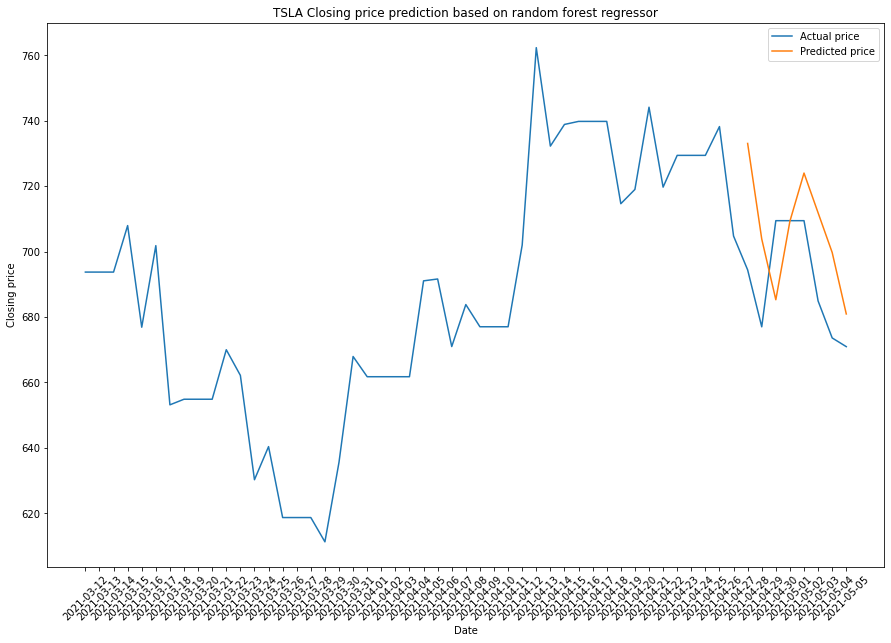

In [209]:

plt.figure(figsize=(15,10))
sns.lineplot(data = rf_tsla_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=rf_tsla_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("TSLA Closing price prediction based on random forest regressor")
plt.show()

In [210]:
lr_tsla_df  =lr_tsla_prediction.select("closing_price","prediction","date").toPandas()
lr_tsla_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="TSLA"].merge(lr_tsla_df,how="left",on="date")

lr_tsla_df.head()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
0  2021-03-12       TSLA            0.040449                        0.04   
1  2021-03-13       TSLA            0.033708                        0.03   
2  2021-03-14       TSLA            0.022472                        0.02   
3  2021-03-15       TSLA            0.109091                        0.11   
4  2021-03-16       TSLA            0.064045                        0.06   

   closing_price_x  positive_sentiment_percentage  closing_price_y  prediction  
0       693.729980                            4.0              NaN         NaN  
1       693.729980                            3.0              NaN         NaN  
2       693.729980                            2.0              NaN         NaN  
3       707.940002                           11.0              NaN         NaN  
4       676.880005                            6.0              NaN         NaN

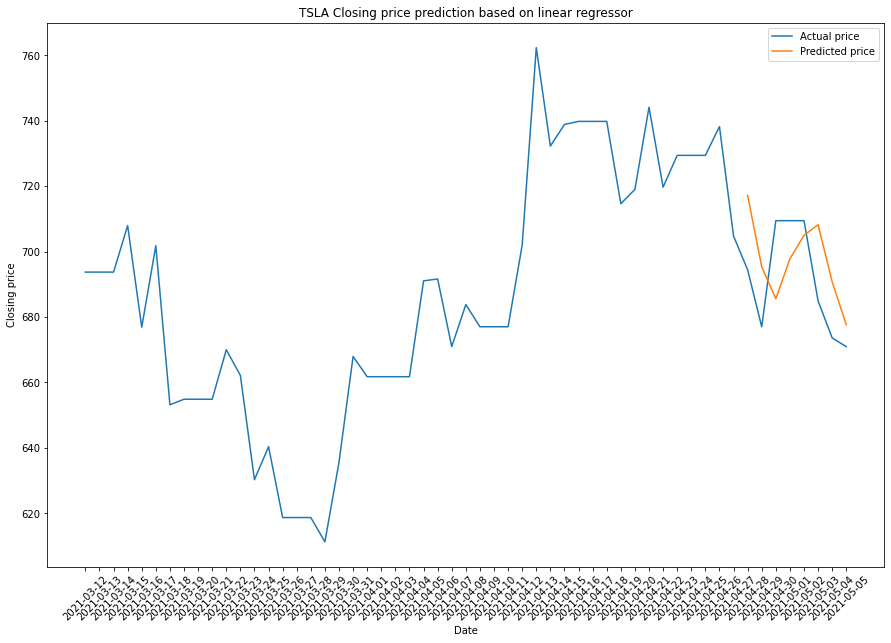

In [211]:
plt.figure(figsize=(15,10))
sns.lineplot(data = lr_tsla_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=lr_tsla_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("TSLA Closing price prediction based on linear regressor")
plt.show()

### Price prediction for Apple stock

In [111]:
vec_assembler =VectorAssembler(inputCols=["one_day_lag_cp","two_day_lag_cp","one_day_lag_sent","two_day_lag_sent"], outputCol="features")

aapl = stock_price_prediction_data.filter(stock_price_prediction_data.stock_name=="AAPL")

aapl_features_data = vec_assembler.transform(aapl)
aapl_features_data.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|2021-03-14|      AAPL|       0.048314605|                      0.05|       121.03|                          5.0|        121.03|        121.03|            0.06|            0.07|[121.029998779296...|
|2021-03-15|      AAPL|       0.062921345|                      0.06|       123.99|                          6.0|        121.03|        121.03|            0.05|            0.06|[121.029998779296...|
|2021

In [212]:
aapl_train_data = aapl_features_data.filter(aapl_features_data.date <= '2021-04-26')
aapl_test_data = aapl_features_data.filter(aapl_features_data.date > '2021-04-27')

In [213]:
rf_aapl_predictor = RandomForestRegressor(featuresCol='features',labelCol='closing_price')
lr_aapl_predictor = LinearRegression(featuresCol='features',labelCol='closing_price')

In [214]:
rf_aapl_predictor = rf_aapl_predictor.fit(aapl_train_data)
lr_aapl_predictor = lr_aapl_predictor.fit(aapl_train_data)

In [215]:
rf_aapl_prediction = rf_aapl_predictor.transform(aapl_test_data)
rf_aapl_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|      AAPL|       0.045146726|                      0.05|       133.58|                          5.0|        134.39|        134.72|            0.06|            0.02|[134.389999389648...|133.83500137329102|
|2021-04-29|      AAPL|        0.05909091|                      0.06|       133.48|                          6.0|        133.58|

In [216]:
lr_aapl_prediction = lr_aapl_predictor.transform(aapl_test_data)
lr_aapl_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|      AAPL|       0.045146726|                      0.05|       133.58|                          5.0|        134.39|        134.72|            0.06|            0.02|[134.389999389648...|135.01436705290217|
|2021-04-29|      AAPL|        0.05909091|                      0.06|       133.48|                          6.0|        133.58|

In [217]:

rf_aapl_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
rf_aapl_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("AAPL")
print("RMSE on test data based on Random Forest regressor: %g" % rf_aapl_evaluator.evaluate(rf_aapl_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
|133.83500137329102|       133.58|[134.389999389648...|
|133.39281299591062|       133.48|[133.580001831054...|
|133.95154532114663|       131.46|[133.479995727539...|
|133.43808795928953|       131.46|[131.460006713867...|
|133.49875219133165|       131.46|[131.460006713867...|
+------------------+-------------+--------------------+
only showing top 5 rows

AAPL
RMSE on test data based on Random Forest regressor: 2.85131


In [218]:

lr_aapl_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
aapl_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("AAPL")
print("RMSE on test data based on linear regressor: %g" % aapl_evaluator.evaluate(lr_aapl_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
|135.01436705290217|       133.58|[134.389999389648...|
|133.72677545365372|       133.48|[133.580001831054...|
| 133.7449975578544|       131.46|[133.479995727539...|
|131.80824378772786|       131.46|[131.460006713867...|
|131.52893382663842|       131.46|[131.460006713867...|
+------------------+-------------+--------------------+
only showing top 5 rows

AAPL
RMSE on test data based on linear regressor: 1.84754


In [219]:
rf_aapl_df  =rf_aapl_prediction.select("closing_price","prediction","date").toPandas()
rf_aapl_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="AAPL"].merge(rf_aapl_df,how="left",on="date")

rf_aapl_df.head()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
0  2021-03-12       AAPL            0.070787                        0.07   
1  2021-03-13       AAPL            0.060714                        0.06   
2  2021-03-14       AAPL            0.048315                        0.05   
3  2021-03-15       AAPL            0.062921                        0.06   
4  2021-03-16       AAPL            0.148984                        0.15   

   closing_price_x  positive_sentiment_percentage  closing_price_y  prediction  
0       121.029999                       7.000000              NaN         NaN  
1       121.029999                       6.000000              NaN         NaN  
2       121.029999                       5.000000              NaN         NaN  
3       123.989998                       6.000000              NaN         NaN  
4       125.570000                      15.000001              NaN         NaN

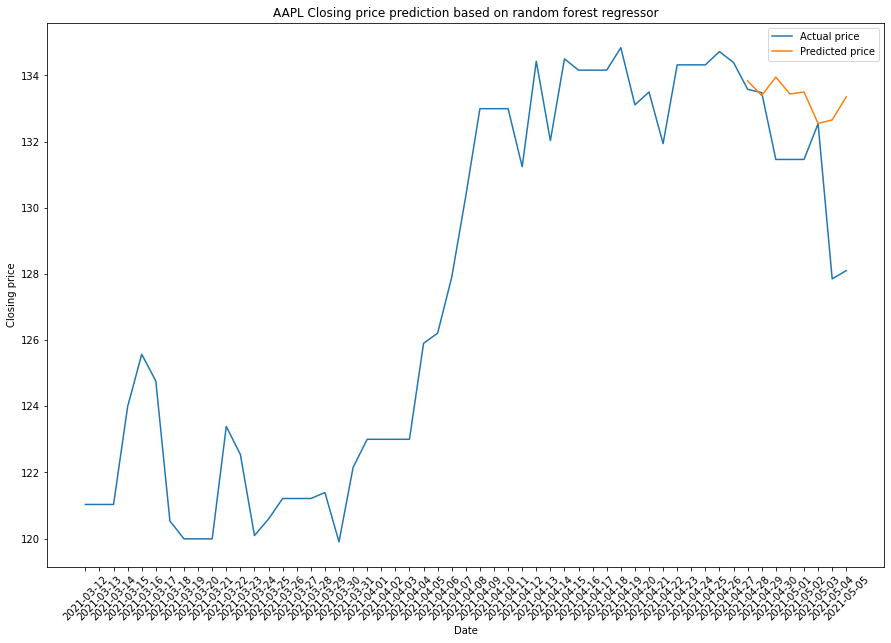

In [220]:

plt.figure(figsize=(15,10))
sns.lineplot(data = rf_aapl_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=rf_aapl_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("AAPL Closing price prediction based on random forest regressor")
plt.show()

In [221]:
lr_aapl_df  =lr_aapl_prediction.select("closing_price","prediction","date").toPandas()
lr_aapl_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="AAPL"].merge(lr_aapl_df,how="left",on="date")

lr_aapl_df.head()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
0  2021-03-12       AAPL            0.070787                        0.07   
1  2021-03-13       AAPL            0.060714                        0.06   
2  2021-03-14       AAPL            0.048315                        0.05   
3  2021-03-15       AAPL            0.062921                        0.06   
4  2021-03-16       AAPL            0.148984                        0.15   

   closing_price_x  positive_sentiment_percentage  closing_price_y  prediction  
0       121.029999                       7.000000              NaN         NaN  
1       121.029999                       6.000000              NaN         NaN  
2       121.029999                       5.000000              NaN         NaN  
3       123.989998                       6.000000              NaN         NaN  
4       125.570000                      15.000001              NaN         NaN

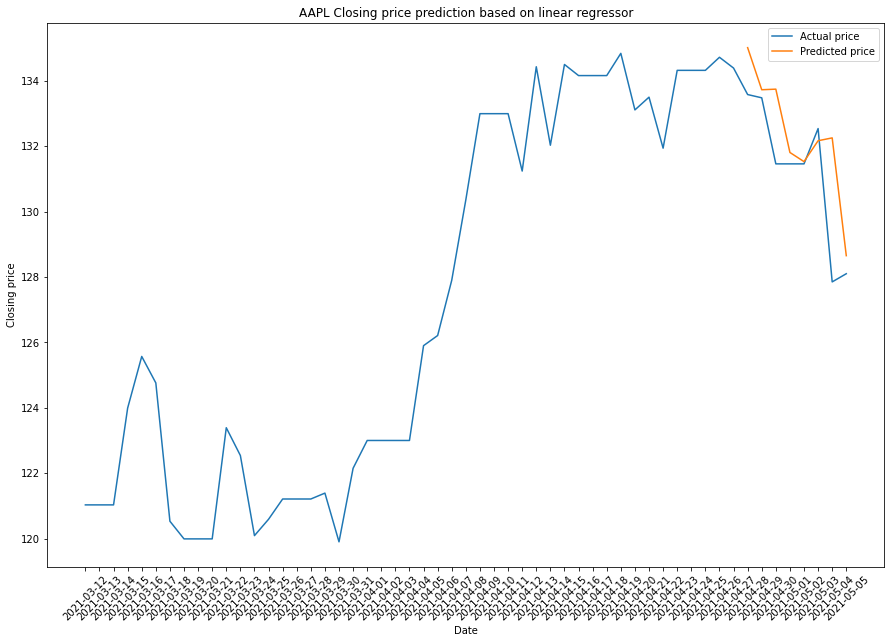

In [222]:
plt.figure(figsize=(15,10))
sns.lineplot(data = lr_aapl_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=lr_aapl_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("AAPL Closing price prediction based on linear regressor")
plt.show()

In [123]:
stocks_list

['LMND', 'ZM', 'OKTA', 'AAPL', 'TSLA', 'FVRR', 'BAC', 'FLGT']

### Price prediction for LMND stock

In [223]:
vec_assembler =VectorAssembler(inputCols=["one_day_lag_cp","two_day_lag_cp","one_day_lag_sent","two_day_lag_sent"], outputCol="features")

lmnd = stock_price_prediction_data.filter(stock_price_prediction_data.stock_name=="LMND")

lmnd_features_data = vec_assembler.transform(lmnd)
lmnd_features_data.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|2021-03-14|      LMND|        0.26126125|                      0.26|       104.54|                         26.0|        104.54|        104.54|            0.07|             0.1|[104.540000915527...|
|2021-03-15|      LMND|        0.08461539|                      0.08|       109.98|                          8.0|        104.54|        104.54|            0.26|            0.07|[104.540000915527...|
|2021

In [224]:
lmnd_train_data = lmnd_features_data.filter(lmnd_features_data.date <= '2021-04-26')
lmnd_test_data = lmnd_features_data.filter(lmnd_features_data.date > '2021-04-27')

In [225]:
rf_lmnd_predictor = RandomForestRegressor(featuresCol='features',labelCol='closing_price')
lr_lmnd_predictor = LinearRegression(featuresCol='features',labelCol='closing_price')

In [226]:
rf_lmnd_predictor = rf_lmnd_predictor.fit(lmnd_train_data)
lr_lmnd_predictor = lr_lmnd_predictor.fit(lmnd_train_data)

In [227]:
rf_lmnd_prediction = rf_lmnd_predictor.transform(lmnd_test_data)
rf_lmnd_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|       prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|2021-04-28|      LMND|        0.09677419|                       0.1|         94.6|                         10.0|         97.17|         97.56|            0.05|            0.04|[97.1699981689453...|97.88537333170574|
|2021-04-29|      LMND|        0.03626943|                      0.04|        92.51|                          4.0|          94.6|    

In [228]:
lr_lmnd_prediction = lr_lmnd_predictor.transform(lmnd_test_data)
lr_lmnd_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|       prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|2021-04-28|      LMND|        0.09677419|                       0.1|         94.6|                         10.0|         97.17|         97.56|            0.05|            0.04|[97.1699981689453...| 95.6398183690088|
|2021-04-29|      LMND|        0.03626943|                      0.04|        92.51|                          4.0|          94.6|    

In [229]:

rf_lmnd_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
rf_lmnd_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("LMND")
print("RMSE on test data based on Random Forest regressor: %g" % rf_lmnd_evaluator.evaluate(rf_lmnd_prediction))

+-----------------+-------------+--------------------+
|       prediction|closing_price|            features|
+-----------------+-------------+--------------------+
|97.88537333170574|         94.6|[97.1699981689453...|
|95.67271035512287|        92.51|[94.5999984741211...|
| 94.2419426695093|         90.4|[92.5100021362304...|
|94.27120969227383|         90.4|[90.4000015258789...|
|93.97291176882659|         90.4|[90.4000015258789...|
+-----------------+-------------+--------------------+
only showing top 5 rows

LMND
RMSE on test data based on Random Forest regressor: 4.24006


In [230]:

lr_lmnd_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_lmnd_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("LMND")
print("RMSE on test data based on linear regressor: %g" % lr_lmnd_evaluator.evaluate(lr_lmnd_prediction))

+-----------------+-------------+--------------------+
|       prediction|closing_price|            features|
+-----------------+-------------+--------------------+
| 95.6398183690088|         94.6|[97.1699981689453...|
|95.26403682604487|        92.51|[94.5999984741211...|
|92.67930904037411|         90.4|[92.5100021362304...|
|91.73922711760432|         90.4|[90.4000015258789...|
|90.10958601173448|         90.4|[90.4000015258789...|
+-----------------+-------------+--------------------+
only showing top 5 rows

LMND
RMSE on test data based on linear regressor: 2.26512


In [231]:
rf_lmnd_df  =rf_lmnd_prediction.select("closing_price","prediction","date").toPandas()
rf_lmnd_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="LMND"].merge(rf_lmnd_df,how="left",on="date")

rf_lmnd_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01       LMND            0.014706                        0.01   
51  2021-05-02       LMND            0.004695                        0.00   
52  2021-05-03       LMND            0.010811                        0.01   
53  2021-05-04       LMND            0.022222                        0.02   
54  2021-05-05       LMND            0.038961                        0.04   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50        90.400002                            1.0        90.400002   
51        90.400002                            0.0        90.400002   
52        86.199997                            1.0        86.199997   
53        83.669998                            2.0        83.669998   
54        81.080002                            4.0        81.080002   

    prediction  
50   94.271210  
51   93.972912  
52   92.841056  
53   88.194987  
54   85.072061

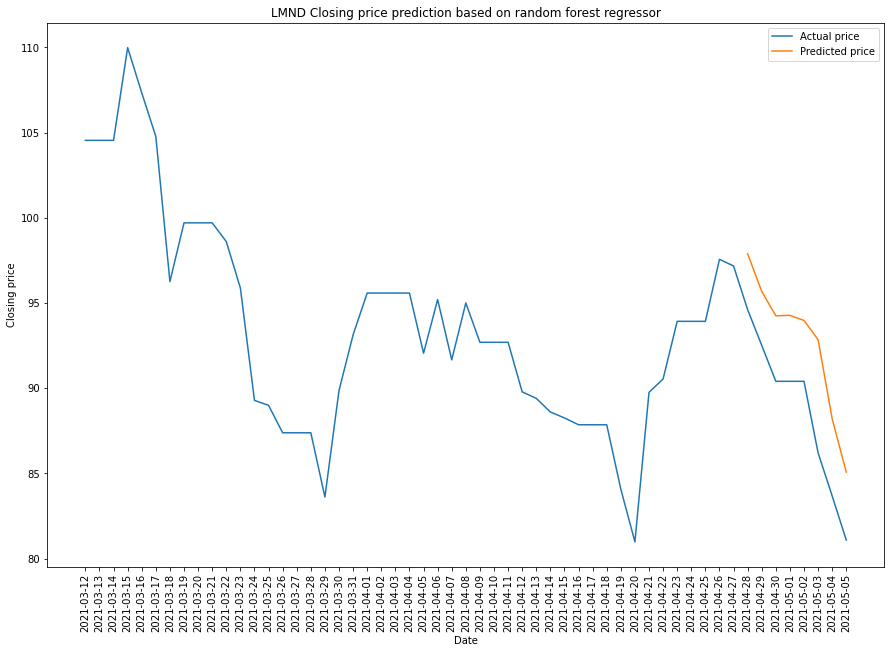

In [235]:

plt.figure(figsize=(15,10))
sns.lineplot(data = rf_lmnd_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=rf_lmnd_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("LMND Closing price prediction based on random forest regressor")
plt.show()

In [233]:
lr_lmnd_df  =lr_lmnd_prediction.select("closing_price","prediction","date").toPandas()
lr_lmnd_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="LMND"].merge(lr_lmnd_df,how="left",on="date")

lr_lmnd_df.head()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
0  2021-03-12       LMND            0.104348                        0.10   
1  2021-03-13       LMND            0.065789                        0.07   
2  2021-03-14       LMND            0.261261                        0.26   
3  2021-03-15       LMND            0.084615                        0.08   
4  2021-03-16       LMND            0.084337                        0.08   

   closing_price_x  positive_sentiment_percentage  closing_price_y  prediction  
0       104.540001                           10.0              NaN         NaN  
1       104.540001                            7.0              NaN         NaN  
2       104.540001                           26.0              NaN         NaN  
3       109.980003                            8.0              NaN         NaN  
4       107.330002                            8.0              NaN         NaN

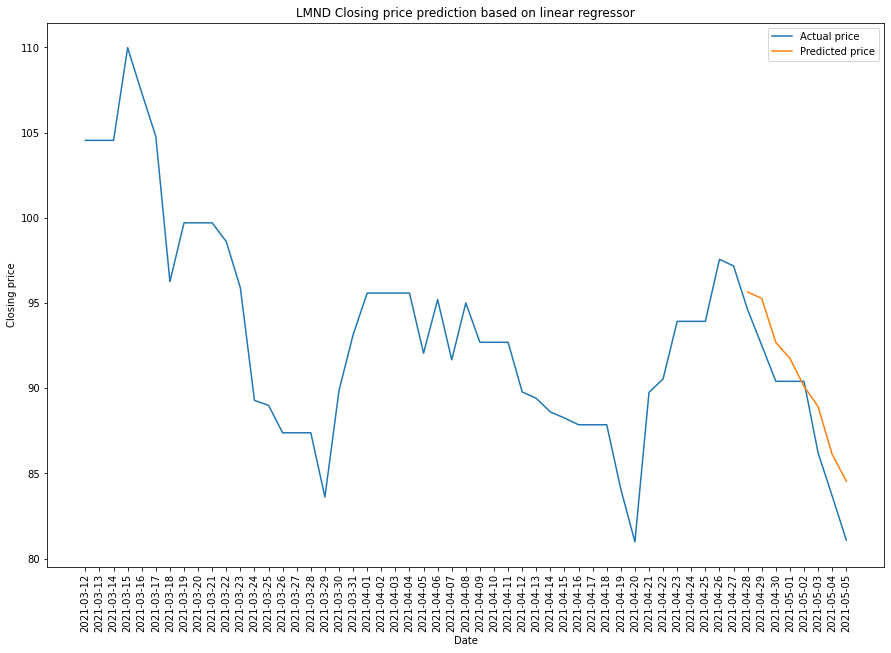

In [236]:
plt.figure(figsize=(15,10))
sns.lineplot(data = lr_lmnd_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=lr_lmnd_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("LMND Closing price prediction based on linear regressor")
plt.show()

### Price prediction for ZM stock

In [237]:
vec_assembler =VectorAssembler(inputCols=["one_day_lag_cp","two_day_lag_cp","one_day_lag_sent","two_day_lag_sent"], outputCol="features")

zm = stock_price_prediction_data.filter(stock_price_prediction_data.stock_name=="ZM")

zm_features_data = vec_assembler.transform(zm)
zm_features_data.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|2021-03-14|        ZM|        0.06853933|                      0.07|       346.39|                          7.0|        346.39|        346.39|             0.1|             0.1|[346.390014648437...|
|2021-03-15|        ZM|       0.061521254|                      0.06|        350.0|                          6.0|        346.39|        346.39|            0.07|             0.1|[346.390014648437...|
|2021

In [238]:
zm_train_data = zm_features_data.filter(zm_features_data.date <= '2021-04-26')
zm_test_data = zm_features_data.filter(zm_features_data.date > '2021-04-27')

In [239]:
rf_zm_predictor = RandomForestRegressor(featuresCol='features',labelCol='closing_price')
lr_zm_predictor = LinearRegression(featuresCol='features',labelCol='closing_price')

In [240]:
rf_zm_predictor = rf_zm_predictor.fit(zm_train_data)
lr_zm_predictor = lr_zm_predictor.fit(zm_train_data)

In [241]:
rf_zm_prediction = rf_zm_predictor.transform(zm_test_data)
rf_zm_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|        ZM|         0.0776153|                      0.08|       331.25|                          8.0|        333.49|        336.42|            0.06|             0.1|[333.489990234375...|329.80499939404916|
|2021-04-29|        ZM|       0.093258426|                      0.09|        321.1|                          9.0|        331.25|

In [242]:
lr_zm_prediction = lr_zm_predictor.transform(zm_test_data)
lr_zm_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|        ZM|         0.0776153|                      0.08|       331.25|                          8.0|        333.49|        336.42|            0.06|             0.1|[333.489990234375...| 330.6149443103113|
|2021-04-29|        ZM|       0.093258426|                      0.09|        321.1|                          9.0|        331.25|

In [243]:

rf_zm_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
rf_zm_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("ZM")
print("RMSE on test data based on Random Forest regressor: %g" % rf_zm_evaluator.evaluate(rf_zm_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
|329.80499939404916|       331.25|[333.489990234375...|
| 326.9886119711117|        321.1|[331.25,333.48999...|
|325.90763191538616|       319.57|[321.100006103515...|
| 321.8060976449166|       319.57|[319.570007324218...|
| 318.9458753764336|       319.57|[319.570007324218...|
+------------------+-------------+--------------------+
only showing top 5 rows

ZM
RMSE on test data based on Random Forest regressor: 9.90071


In [244]:

lr_zm_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_zm_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("ZM")
print("RMSE on test data based on linear regressor: %g" % lr_zm_evaluator.evaluate(lr_zm_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
| 330.6149443103113|       331.25|[333.489990234375...|
|330.03927760745455|        321.1|[331.25,333.48999...|
|324.46806399996785|       319.57|[321.100006103515...|
|321.35240945637486|       319.57|[319.570007324218...|
| 322.1380403768085|       319.57|[319.570007324218...|
+------------------+-------------+--------------------+
only showing top 5 rows

ZM
RMSE on test data based on linear regressor: 9.46804


In [245]:
rf_zm_df  =rf_zm_prediction.select("closing_price","prediction","date").toPandas()
rf_zm_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="ZM"].merge(rf_zm_df,how="left",on="date")

rf_zm_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01         ZM            0.095506                        0.10   
51  2021-05-02         ZM            0.122549                        0.12   
52  2021-05-03         ZM            0.057303                        0.06   
53  2021-05-04         ZM            0.218223                        0.22   
54  2021-05-05         ZM            0.085393                        0.09   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50       319.570007                           10.0       319.570007   
51       319.570007                           12.0       319.570007   
52       313.920013                            6.0       313.920013   
53       304.850006                           22.0       304.850006   
54       297.589996                            9.0       297.589996   

    prediction  
50  321.806098  
51  318.945875  
52  316.542876  
53  316.292850  
54  321.339864

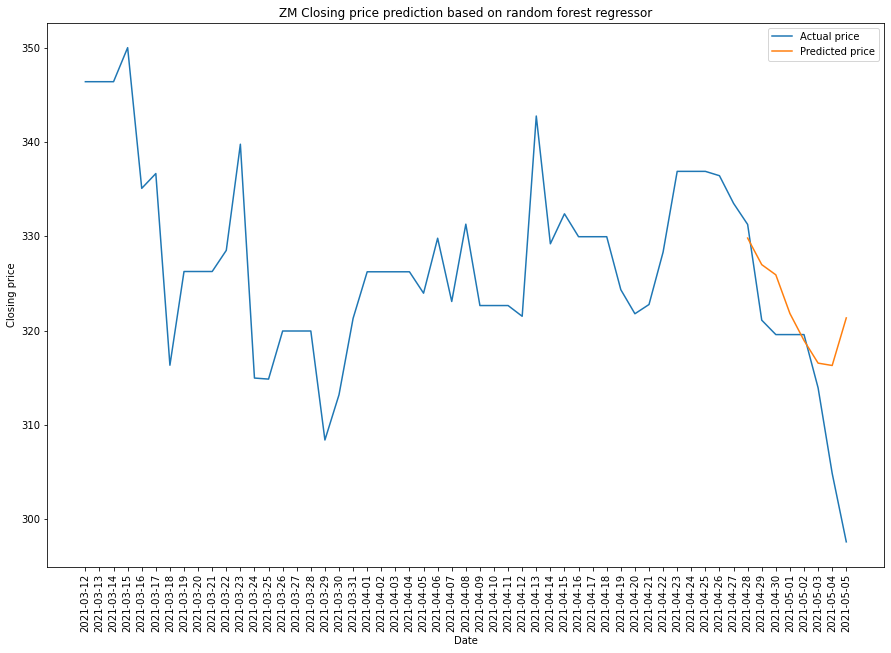

In [246]:

plt.figure(figsize=(15,10))
sns.lineplot(data = rf_zm_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=rf_zm_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("ZM Closing price prediction based on random forest regressor")
plt.show()

In [247]:
lr_zm_df  =lr_zm_prediction.select("closing_price","prediction","date").toPandas()
lr_zm_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="ZM"].merge(lr_zm_df,how="left",on="date")

lr_zm_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01         ZM            0.095506                        0.10   
51  2021-05-02         ZM            0.122549                        0.12   
52  2021-05-03         ZM            0.057303                        0.06   
53  2021-05-04         ZM            0.218223                        0.22   
54  2021-05-05         ZM            0.085393                        0.09   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50       319.570007                           10.0       319.570007   
51       319.570007                           12.0       319.570007   
52       313.920013                            6.0       313.920013   
53       304.850006                           22.0       304.850006   
54       297.589996                            9.0       297.589996   

    prediction  
50  321.352409  
51  322.138040  
52  322.243158  
53  317.549402  
54  316.890898

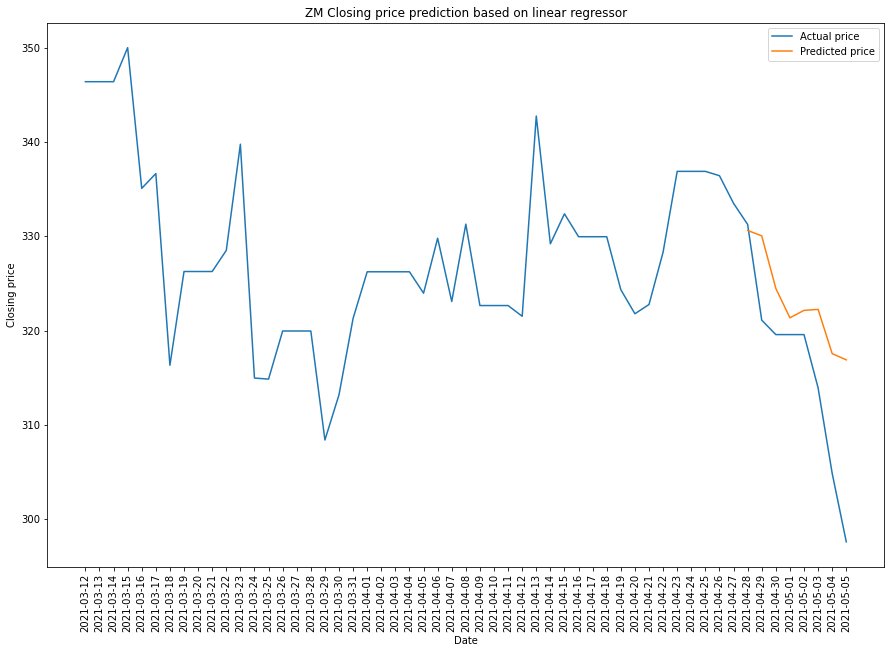

In [248]:
plt.figure(figsize=(15,10))
sns.lineplot(data = lr_zm_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=lr_zm_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("ZM Closing price prediction based on linear regressor")
plt.show()

In [148]:
stocks_list

['LMND', 'ZM', 'OKTA', 'AAPL', 'TSLA', 'FVRR', 'BAC', 'FLGT']

### Price prediction for OKTA stock

In [249]:
vec_assembler =VectorAssembler(inputCols=["one_day_lag_cp","two_day_lag_cp","one_day_lag_sent","two_day_lag_sent"], outputCol="features")

okta = stock_price_prediction_data.filter(stock_price_prediction_data.stock_name=="OKTA")

okta_features_data = vec_assembler.transform(okta)
okta_features_data.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|2021-03-14|      OKTA|        0.18098159|                      0.18|        227.0|                         18.0|         227.0|         227.0|            0.26|            0.07|[227.0,227.0,0.25...|
|2021-03-15|      OKTA|       0.097402595|                       0.1|       228.72|                         10.0|         227.0|         227.0|            0.18|            0.26|[227.0,227.0,0.18...|
|2021

In [250]:
okta_train_data = okta_features_data.filter(okta_features_data.date <= '2021-04-26')
okta_test_data = okta_features_data.filter(okta_features_data.date > '2021-04-27')

In [251]:
rf_okta_predictor = RandomForestRegressor(featuresCol='features',labelCol='closing_price')
lr_okta_predictor = LinearRegression(featuresCol='features',labelCol='closing_price')

In [252]:
rf_okta_predictor = rf_okta_predictor.fit(okta_train_data)
lr_okta_predictor = lr_okta_predictor.fit(okta_train_data)

In [253]:
rf_okta_prediction = rf_okta_predictor.transform(okta_test_data)
rf_okta_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|      OKTA|        0.07317073|                      0.07|       281.84|                          7.0|         283.0|        285.35|            0.13|            0.11|[283.0,285.350006...| 281.3548299153646|
|2021-04-29|      OKTA|        0.14893617|                      0.15|       273.62|                    15.000001|        281.84|

In [254]:
lr_okta_prediction = lr_okta_predictor.transform(okta_test_data)
lr_okta_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|      OKTA|        0.07317073|                      0.07|       281.84|                          7.0|         283.0|        285.35|            0.13|            0.11|[283.0,285.350006...|285.73321750190297|
|2021-04-29|      OKTA|        0.14893617|                      0.15|       273.62|                    15.000001|        281.84|

In [255]:

rf_okta_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
rf_okta_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("OKTA")
print("RMSE on test data based on Random Forest regressor: %g" % rf_okta_evaluator.evaluate(rf_okta_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
| 281.3548299153646|       281.84|[283.0,285.350006...|
| 276.5379951477051|       273.62|[281.839996337890...|
|274.90072780790786|        269.7|[273.619995117187...|
|272.49269426618304|        269.7|[269.700012207031...|
|270.06180195762994|        269.7|[269.700012207031...|
+------------------+-------------+--------------------+
only showing top 5 rows

OKTA
RMSE on test data based on Random Forest regressor: 12.0713


In [256]:

lr_okta_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_okta_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("OKTA")
print("RMSE on test data based on linear regressor: %g" % lr_okta_evaluator.evaluate(lr_okta_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
|285.73321750190297|       281.84|[283.0,285.350006...|
|283.62450605654647|       273.62|[281.839996337890...|
| 277.4788686038617|        269.7|[273.619995117187...|
|  272.547119332089|        269.7|[269.700012207031...|
|271.30945975949277|        269.7|[269.700012207031...|
+------------------+-------------+--------------------+
only showing top 5 rows

OKTA
RMSE on test data based on linear regressor: 9.72531


In [257]:
rf_okta_df  =rf_okta_prediction.select("closing_price","prediction","date").toPandas()
rf_okta_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="OKTA"].merge(rf_okta_df,how="left",on="date")

rf_okta_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01       OKTA            0.113043                        0.11   
51  2021-05-02       OKTA            0.129944                        0.13   
52  2021-05-03       OKTA            0.214286                        0.21   
53  2021-05-04       OKTA            0.279891                        0.28   
54  2021-05-05       OKTA            0.163347                        0.16   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50       269.700012                           11.0       269.700012   
51       269.700012                           13.0       269.700012   
52       255.919998                           21.0       255.919998   
53       244.070007                           28.0       244.070007   
54       242.059998                           16.0       242.059998   

    prediction  
50  272.492694  
51  270.061802  
52  269.688804  
53  269.652182  
54  258.732811

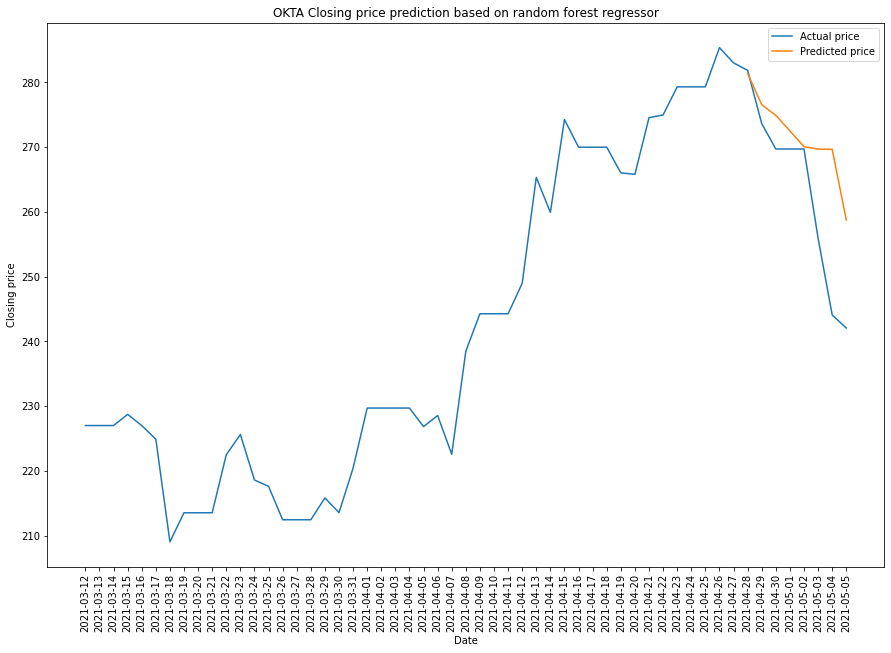

In [258]:

plt.figure(figsize=(15,10))
sns.lineplot(data = rf_okta_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=rf_okta_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("OKTA Closing price prediction based on random forest regressor")
plt.show()

In [259]:
lr_okta_df  =lr_okta_prediction.select("closing_price","prediction","date").toPandas()
lr_okta_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="OKTA"].merge(lr_okta_df,how="left",on="date")

lr_okta_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01       OKTA            0.113043                        0.11   
51  2021-05-02       OKTA            0.129944                        0.13   
52  2021-05-03       OKTA            0.214286                        0.21   
53  2021-05-04       OKTA            0.279891                        0.28   
54  2021-05-05       OKTA            0.163347                        0.16   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50       269.700012                           11.0       269.700012   
51       269.700012                           13.0       269.700012   
52       255.919998                           21.0       255.919998   
53       244.070007                           28.0       244.070007   
54       242.059998                           16.0       242.059998   

    prediction  
50  272.547119  
51  271.309460  
52  271.709185  
53  260.708434  
54  248.698012

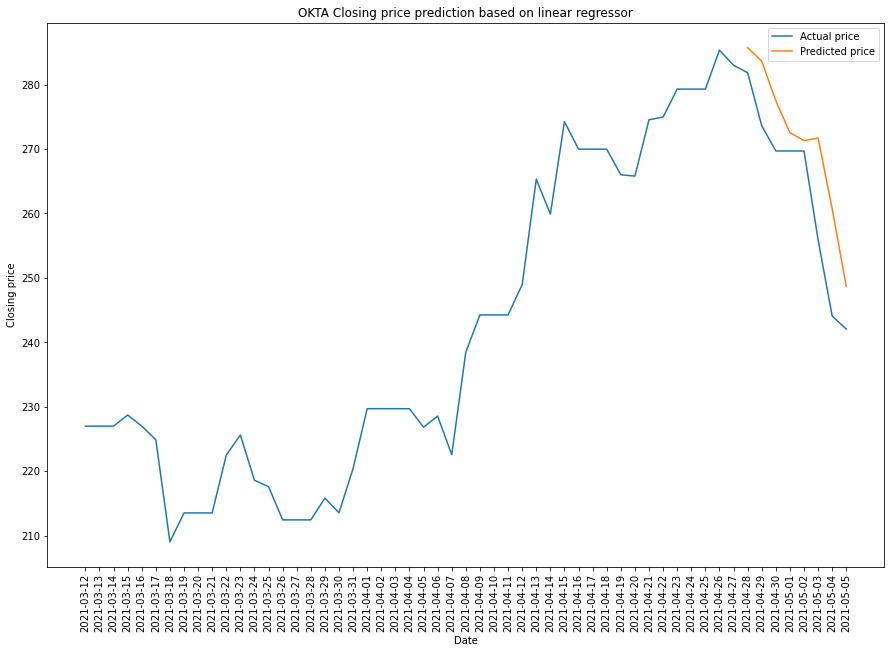

In [260]:
plt.figure(figsize=(15,10))
sns.lineplot(data = lr_okta_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=lr_okta_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("OKTA Closing price prediction based on linear regressor")
plt.show()

In [261]:
stocks_list

['LMND', 'ZM', 'OKTA', 'AAPL', 'TSLA', 'FVRR', 'BAC', 'FLGT']

### Price prediction for FVRR stock

In [262]:
vec_assembler =VectorAssembler(inputCols=["one_day_lag_cp","two_day_lag_cp","one_day_lag_sent","two_day_lag_sent"], outputCol="features")

fvrr = stock_price_prediction_data.filter(stock_price_prediction_data.stock_name=="FVRR")

fvrr_features_data = vec_assembler.transform(fvrr)
fvrr_features_data.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|2021-03-14|      FVRR|        0.01010101|                      0.01|       243.88|                          1.0|        243.88|        243.88|            0.04|             0.0|[243.880004882812...|
|2021-03-15|      FVRR|               0.0|                       0.0|       241.31|                          0.0|        243.88|        243.88|            0.01|            0.04|[243.880004882812...|
|2021

In [263]:
fvrr_train_data = fvrr_features_data.filter(fvrr_features_data.date <= '2021-04-26')
fvrr_test_data = fvrr_features_data.filter(fvrr_features_data.date > '2021-04-27')

In [264]:
rf_fvrr_predictor = RandomForestRegressor(featuresCol='features',labelCol='closing_price')
lr_fvrr_predictor = LinearRegression(featuresCol='features',labelCol='closing_price')

In [265]:
rf_fvrr_predictor = rf_fvrr_predictor.fit(fvrr_train_data)
lr_fvrr_predictor = lr_fvrr_predictor.fit(fvrr_train_data)

In [266]:
rf_fvrr_prediction = rf_fvrr_predictor.transform(fvrr_test_data)
rf_fvrr_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|      FVRR|              0.26|                      0.26|       222.66|                         26.0|        224.25|        225.08|            0.03|             0.0|[224.25,225.08000...| 225.2310646709981|
|2021-04-29|      FVRR|               0.0|                       0.0|       215.19|                          0.0|        222.66|

In [267]:
lr_fvrr_prediction = lr_fvrr_predictor.transform(fvrr_test_data)
lr_fvrr_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|      FVRR|              0.26|                      0.26|       222.66|                         26.0|        224.25|        225.08|            0.03|             0.0|[224.25,225.08000...| 222.9660539008175|
|2021-04-29|      FVRR|               0.0|                       0.0|       215.19|                          0.0|        222.66|

In [268]:

rf_fvrr_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
rf_fvrr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("FVRR")
print("RMSE on test data based on Random Forest regressor: %g" % rf_fvrr_evaluator.evaluate(rf_fvrr_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
| 225.2310646709981|       222.66|[224.25,225.08000...|
|223.29234973002946|       215.19|[222.660003662109...|
|217.55485688535683|       208.07|[215.190002441406...|
| 214.1073371442159|       208.07|[208.070007324218...|
| 214.6510920139671|       208.07|[208.070007324218...|
+------------------+-------------+--------------------+
only showing top 5 rows

FVRR
RMSE on test data based on Random Forest regressor: 12.4217


In [269]:

lr_fvrr_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_fvrr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("FVRR")
print("RMSE on test data based on linear regressor: %g" % lr_fvrr_evaluator.evaluate(lr_fvrr_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
| 222.9660539008175|       222.66|[224.25,225.08000...|
|224.25008880429925|       215.19|[222.660003662109...|
|214.76714291460598|       208.07|[215.190002441406...|
|210.59038863199325|       208.07|[208.070007324218...|
|210.30528159068692|       208.07|[208.070007324218...|
+------------------+-------------+--------------------+
only showing top 5 rows

FVRR
RMSE on test data based on linear regressor: 8.69848


In [270]:
rf_fvrr_df  =rf_fvrr_prediction.select("closing_price","prediction","date").toPandas()
rf_fvrr_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="FVRR"].merge(rf_fvrr_df,how="left",on="date")

rf_fvrr_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01       FVRR            0.042755                        0.04   
51  2021-05-02       FVRR            0.067797                        0.07   
52  2021-05-03       FVRR            0.043956                        0.04   
53  2021-05-04       FVRR            0.015748                        0.02   
54  2021-05-05       FVRR            0.016304                        0.02   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50       208.070007                            4.0       208.070007   
51       208.070007                            7.0       208.070007   
52       200.440002                            4.0       200.440002   
53       191.669998                            2.0       191.669998   
54       183.880005                            2.0       183.880005   

    prediction  
50  214.107337  
51  214.651092  
52  213.748446  
53  210.369280  
54  205.458669

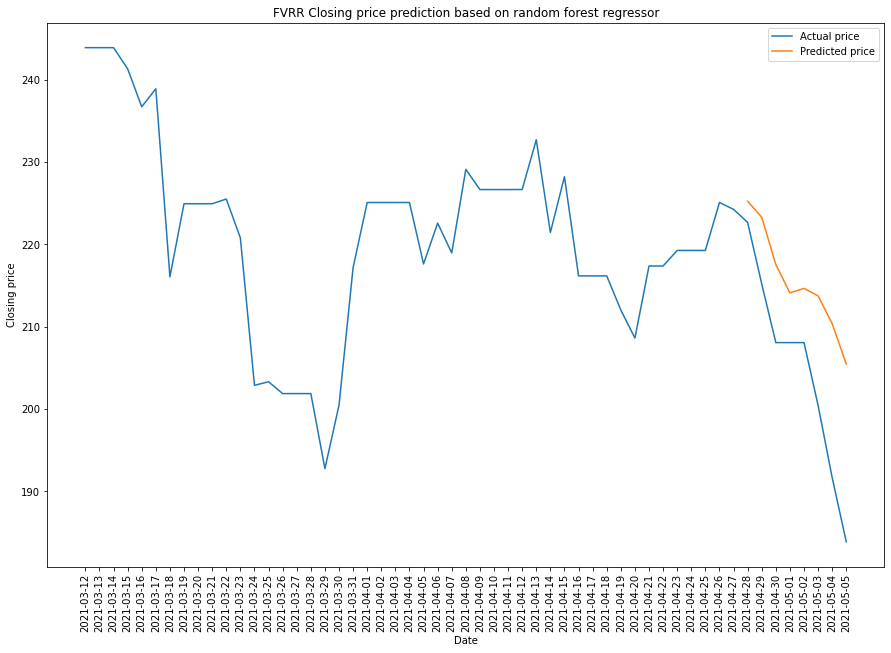

In [271]:

plt.figure(figsize=(15,10))
sns.lineplot(data = rf_fvrr_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=rf_fvrr_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("FVRR Closing price prediction based on random forest regressor")
plt.show()

In [272]:
lr_fvrr_df  =lr_fvrr_prediction.select("closing_price","prediction","date").toPandas()
lr_fvrr_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="FVRR"].merge(lr_fvrr_df,how="left",on="date")

lr_fvrr_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01       FVRR            0.042755                        0.04   
51  2021-05-02       FVRR            0.067797                        0.07   
52  2021-05-03       FVRR            0.043956                        0.04   
53  2021-05-04       FVRR            0.015748                        0.02   
54  2021-05-05       FVRR            0.016304                        0.02   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50       208.070007                            4.0       208.070007   
51       208.070007                            7.0       208.070007   
52       200.440002                            4.0       200.440002   
53       191.669998                            2.0       191.669998   
54       183.880005                            2.0       183.880005   

    prediction  
50  210.590389  
51  210.305282  
52  210.424791  
53  204.726843  
54  197.906824

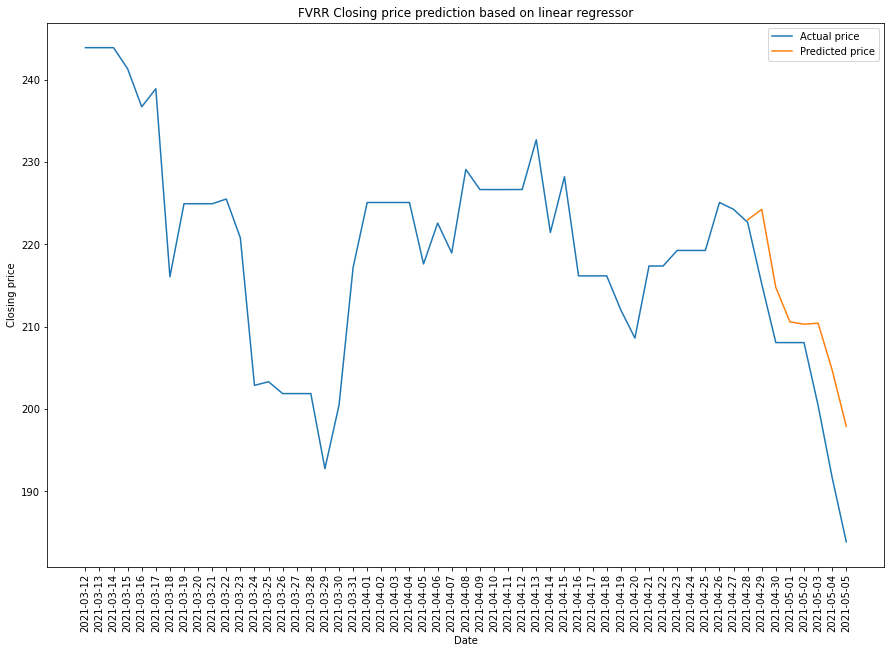

In [273]:
plt.figure(figsize=(15,10))
sns.lineplot(data = lr_fvrr_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=lr_fvrr_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("FVRR Closing price prediction based on linear regressor")
plt.show()

In [274]:
stocks_list

['LMND', 'ZM', 'OKTA', 'AAPL', 'TSLA', 'FVRR', 'BAC', 'FLGT']

### Price prediction for BAC stock

In [275]:
vec_assembler =VectorAssembler(inputCols=["one_day_lag_cp","two_day_lag_cp","one_day_lag_sent","two_day_lag_sent"], outputCol="features")

bac = stock_price_prediction_data.filter(stock_price_prediction_data.stock_name=="BAC")

bac_features_data = vec_assembler.transform(bac)
bac_features_data.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|2021-03-14|       BAC|        0.22834645|                      0.23|        37.94|                         23.0|         37.94|         37.94|            0.26|            0.24|[37.9399986267089...|
|2021-03-15|       BAC|         0.2231405|                      0.22|        37.75|                         22.0|         37.94|         37.94|            0.23|            0.26|[37.9399986267089...|
|2021

In [276]:
bac_train_data = bac_features_data.filter(bac_features_data.date <= '2021-04-26')
bac_test_data = bac_features_data.filter(bac_features_data.date > '2021-04-27')

In [277]:
rf_bac_predictor = RandomForestRegressor(featuresCol='features',labelCol='closing_price')
lr_bac_predictor = LinearRegression(featuresCol='features',labelCol='closing_price')

In [278]:
rf_bac_predictor = rf_bac_predictor.fit(bac_train_data)
lr_bac_predictor = lr_bac_predictor.fit(bac_train_data)

In [279]:
rf_bac_prediction = rf_bac_predictor.transform(bac_test_data)
rf_bac_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|       BAC|          0.280226|                      0.28|        40.03|                         28.0|         39.88|         39.41|            0.33|            0.24|[39.8800010681152...|39.667515654708396|
|2021-04-29|       BAC|        0.29246345|                      0.29|        41.11|                         29.0|         40.03|

In [280]:
lr_bac_prediction = lr_bac_predictor.transform(bac_test_data)
lr_bac_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|        prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+------------------+
|2021-04-28|       BAC|          0.280226|                      0.28|        40.03|                         28.0|         39.88|         39.41|            0.33|            0.24|[39.8800010681152...|39.732426252372335|
|2021-04-29|       BAC|        0.29246345|                      0.29|        41.11|                         29.0|         40.03|

In [281]:

rf_bac_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
rf_bac_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("BAC")
print("RMSE on test data based on Random Forest regressor: %g" % rf_bac_evaluator.evaluate(rf_bac_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
|39.667515654708396|        40.03|[39.8800010681152...|
| 39.71722453608657|        41.11|[40.0299987792968...|
| 39.62991217150832|        40.53|[41.1100006103515...|
| 39.65776211276199|        40.53|[40.5299987792968...|
| 39.81126239950006|        40.53|[40.5299987792968...|
+------------------+-------------+--------------------+
only showing top 5 rows

BAC
RMSE on test data based on Random Forest regressor: 1.13942


In [282]:

lr_bac_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_bac_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("BAC")
print("RMSE on test data based on linear regressor: %g" % lr_bac_evaluator.evaluate(lr_bac_prediction))

+------------------+-------------+--------------------+
|        prediction|closing_price|            features|
+------------------+-------------+--------------------+
|39.732426252372335|        40.03|[39.8800010681152...|
|39.823891310304816|        41.11|[40.0299987792968...|
|  40.6231799759757|        40.53|[41.1100006103515...|
| 40.36187719856974|        40.53|[40.5299987792968...|
| 40.26628929681917|        40.53|[40.5299987792968...|
+------------------+-------------+--------------------+
only showing top 5 rows

BAC
RMSE on test data based on linear regressor: 0.630434


In [283]:
rf_bac_df  =rf_bac_prediction.select("closing_price","prediction","date").toPandas()
rf_bac_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="BAC"].merge(rf_bac_df,how="left",on="date")

rf_bac_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01        BAC            0.222722                        0.22   
51  2021-05-02        BAC            0.556433                        0.56   
52  2021-05-03        BAC            0.305618                        0.31   
53  2021-05-04        BAC            0.250844                        0.25   
54  2021-05-05        BAC            0.291339                        0.29   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50        40.529999                           22.0        40.529999   
51        40.529999                           56.0        40.529999   
52        40.560001                           31.0        40.560001   
53        41.000000                           25.0        41.000000   
54        41.389999                           29.0        41.389999   

    prediction  
50   39.657762  
51   39.811262  
52   39.709251  
53   39.427442  
54   39.649095

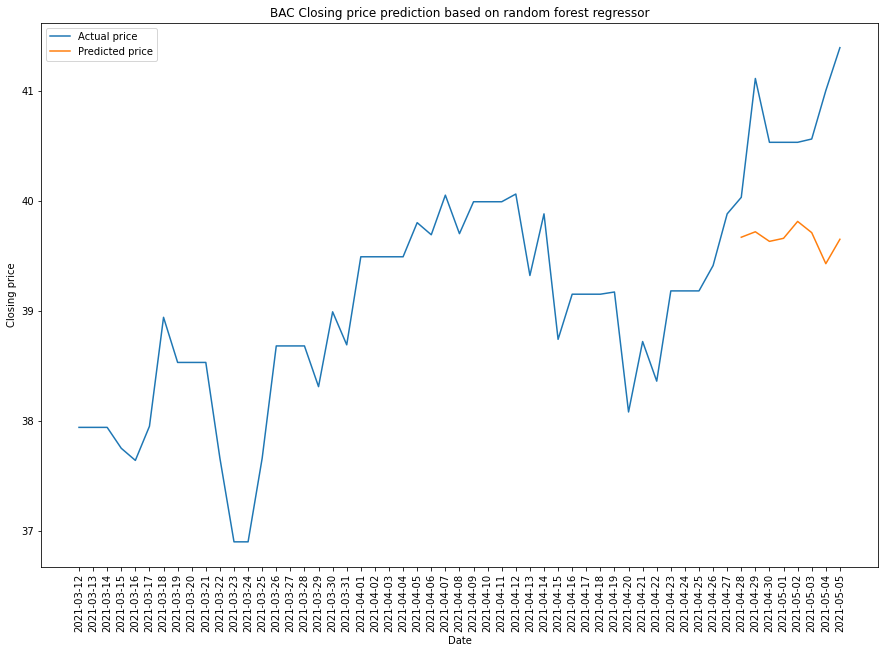

In [284]:

plt.figure(figsize=(15,10))
sns.lineplot(data = rf_bac_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=rf_bac_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("BAC Closing price prediction based on random forest regressor")
plt.show()

In [285]:
lr_bac_df  =lr_bac_prediction.select("closing_price","prediction","date").toPandas()
lr_bac_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="BAC"].merge(lr_bac_df,how="left",on="date")

lr_bac_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01        BAC            0.222722                        0.22   
51  2021-05-02        BAC            0.556433                        0.56   
52  2021-05-03        BAC            0.305618                        0.31   
53  2021-05-04        BAC            0.250844                        0.25   
54  2021-05-05        BAC            0.291339                        0.29   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50        40.529999                           22.0        40.529999   
51        40.529999                           56.0        40.529999   
52        40.560001                           31.0        40.560001   
53        41.000000                           25.0        41.000000   
54        41.389999                           29.0        41.389999   

    prediction  
50   40.361877  
51   40.266289  
52   40.504430  
53   40.175881  
54   40.584891

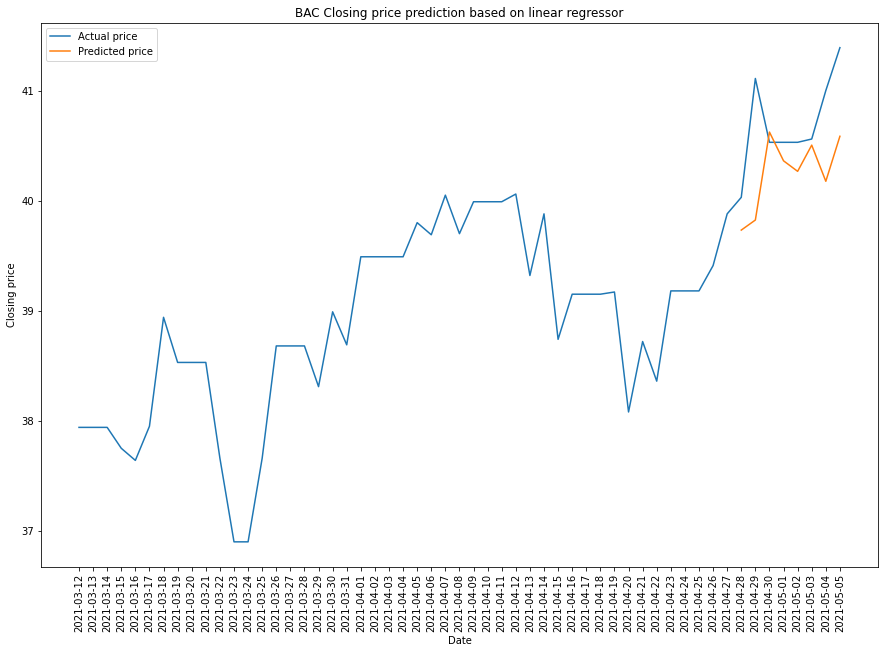

In [286]:
plt.figure(figsize=(15,10))
sns.lineplot(data = lr_bac_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=lr_bac_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("BAC Closing price prediction based on linear regressor")
plt.show()

### Price prediction for FLGT stock

In [287]:
vec_assembler =VectorAssembler(inputCols=["one_day_lag_cp","two_day_lag_cp","one_day_lag_sent","two_day_lag_sent"], outputCol="features")

flgt = stock_price_prediction_data.filter(stock_price_prediction_data.stock_name=="FLGT")

flgt_features_data = vec_assembler.transform(flgt)
flgt_features_data.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+
|2021-03-14|      FLGT|             0.525|                      0.52|         95.6|                         52.0|          95.6|          95.6|            0.18|            0.19|[95.5999984741211...|
|2021-03-15|      FLGT|        0.36082473|                      0.36|       104.27|                         36.0|          95.6|          95.6|            0.52|            0.18|[95.5999984741211...|
|2021

In [288]:
flgt_train_data = flgt_features_data.filter(flgt_features_data.date <= '2021-04-26')
flgt_test_data = flgt_features_data.filter(flgt_features_data.date > '2021-04-27')

In [289]:
rf_flgt_predictor = RandomForestRegressor(featuresCol='features',labelCol='closing_price')
lr_flgt_predictor = LinearRegression(featuresCol='features',labelCol='closing_price')

In [290]:
rf_flgt_predictor = rf_flgt_predictor.fit(flgt_train_data)
lr_flgt_predictor = lr_flgt_predictor.fit(flgt_train_data)

In [291]:
rf_flgt_prediction = rf_flgt_predictor.transform(flgt_test_data)
rf_flgt_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|       prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|2021-04-28|      FLGT|        0.22222222|                      0.22|        87.64|                         22.0|         87.19|          87.7|             0.0|            0.05|[87.1900024414062...|88.43841725667318|
|2021-04-29|      FLGT|               0.0|                       0.0|        79.59|                          0.0|         87.64|    

In [292]:
lr_flgt_prediction = lr_flgt_predictor.transform(flgt_test_data)
lr_flgt_prediction.show()

+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|      date|stock_name|positive_sentiment|positive_sentiment_rounded|closing_price|positive_sentiment_percentage|one_day_lag_cp|two_day_lag_cp|one_day_lag_sent|two_day_lag_sent|            features|       prediction|
+----------+----------+------------------+--------------------------+-------------+-----------------------------+--------------+--------------+----------------+----------------+--------------------+-----------------+
|2021-04-28|      FLGT|        0.22222222|                      0.22|        87.64|                         22.0|         87.19|          87.7|             0.0|            0.05|[87.1900024414062...|87.18511595932526|
|2021-04-29|      FLGT|               0.0|                       0.0|        79.59|                          0.0|         87.64|    

In [293]:

rf_flgt_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
rf_flgt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("FLGT")
print("RMSE on test data based on Random Forest regressor: %g" % rf_flgt_evaluator.evaluate(rf_flgt_prediction))

+-----------------+-------------+--------------------+
|       prediction|closing_price|            features|
+-----------------+-------------+--------------------+
|88.43841725667318|        87.64|[87.1900024414062...|
|87.60899932861328|        79.59|[87.6399993896484...|
|86.45515318522378|        77.02|[79.5899963378906...|
|87.23117517471313|        77.02|[77.0199966430664...|
|86.71071615854899|        77.02|[77.0199966430664...|
+-----------------+-------------+--------------------+
only showing top 5 rows

FLGT
RMSE on test data based on Random Forest regressor: 10.0978


In [294]:

lr_flgt_prediction.select("prediction","closing_price","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_flgt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="closing_price",metricName="rmse")
print("FLGT")
print("RMSE on test data based on linear regressor: %g" % lr_flgt_evaluator.evaluate(lr_flgt_prediction))

+-----------------+-------------+--------------------+
|       prediction|closing_price|            features|
+-----------------+-------------+--------------------+
|87.18511595932526|        87.64|[87.1900024414062...|
| 87.2930352988239|        79.59|[87.6399993896484...|
|81.74425397644097|        77.02|[79.5899963378906...|
|78.08717921435456|        77.02|[77.0199966430664...|
| 78.1792531443954|        77.02|[77.0199966430664...|
+-----------------+-------------+--------------------+
only showing top 5 rows

FLGT
RMSE on test data based on linear regressor: 3.88928


In [295]:
rf_flgt_df  =rf_flgt_prediction.select("closing_price","prediction","date").toPandas()
rf_flgt_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="FLGT"].merge(rf_flgt_df,how="left",on="date")

rf_flgt_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01       FLGT            0.100000                        0.10   
51  2021-05-02       FLGT            0.111111                        0.11   
52  2021-05-03       FLGT            0.138889                        0.14   
53  2021-05-04       FLGT            0.050000                        0.05   
54  2021-05-05       FLGT            0.046512                        0.05   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50        77.019997                           10.0        77.019997   
51        77.019997                           11.0        77.019997   
52        76.480003                           14.0        76.480003   
53        74.139999                            5.0        74.139999   
54        71.849998                            5.0        71.849998   

    prediction  
50   87.231175  
51   86.710716  
52   86.710716  
53   86.267279  
54   86.404630

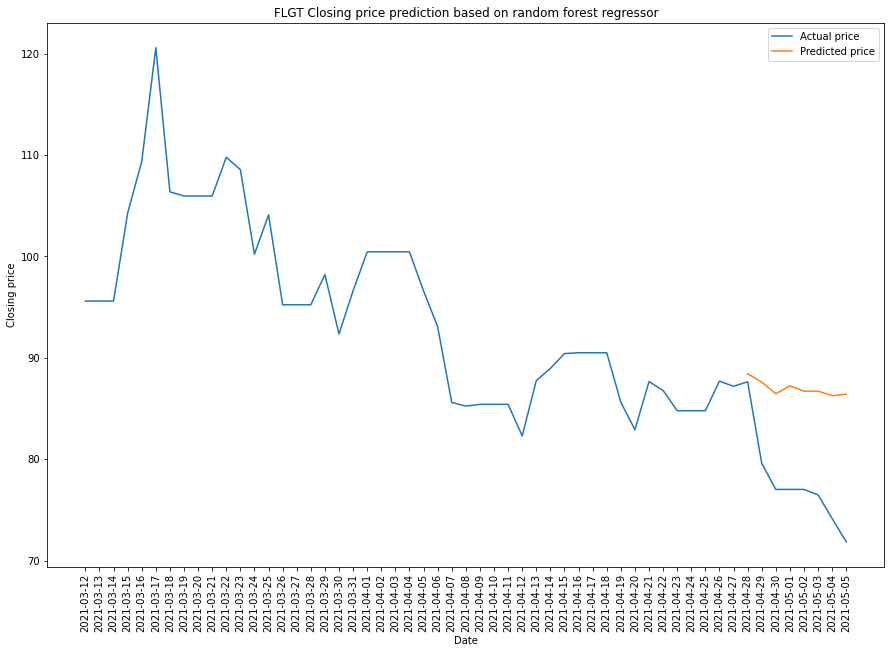

In [296]:

plt.figure(figsize=(15,10))
sns.lineplot(data = rf_flgt_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=rf_flgt_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("FLGT Closing price prediction based on random forest regressor")
plt.show()

In [297]:
lr_flgt_df  =lr_flgt_prediction.select("closing_price","prediction","date").toPandas()
lr_flgt_df = sentiment_closing_price_pd_df[sentiment_closing_price_pd_df["stock_name"]=="FLGT"].merge(lr_flgt_df,how="left",on="date")

lr_flgt_df.tail()

date stock_name  positive_sentiment  positive_sentiment_rounded  \
50  2021-05-01       FLGT            0.100000                        0.10   
51  2021-05-02       FLGT            0.111111                        0.11   
52  2021-05-03       FLGT            0.138889                        0.14   
53  2021-05-04       FLGT            0.050000                        0.05   
54  2021-05-05       FLGT            0.046512                        0.05   

    closing_price_x  positive_sentiment_percentage  closing_price_y  \
50        77.019997                           10.0        77.019997   
51        77.019997                           11.0        77.019997   
52        76.480003                           14.0        76.480003   
53        74.139999                            5.0        74.139999   
54        71.849998                            5.0        71.849998   

    prediction  
50   78.087179  
51   78.179253  
52   78.360386  
53   77.965027  
54   76.151197

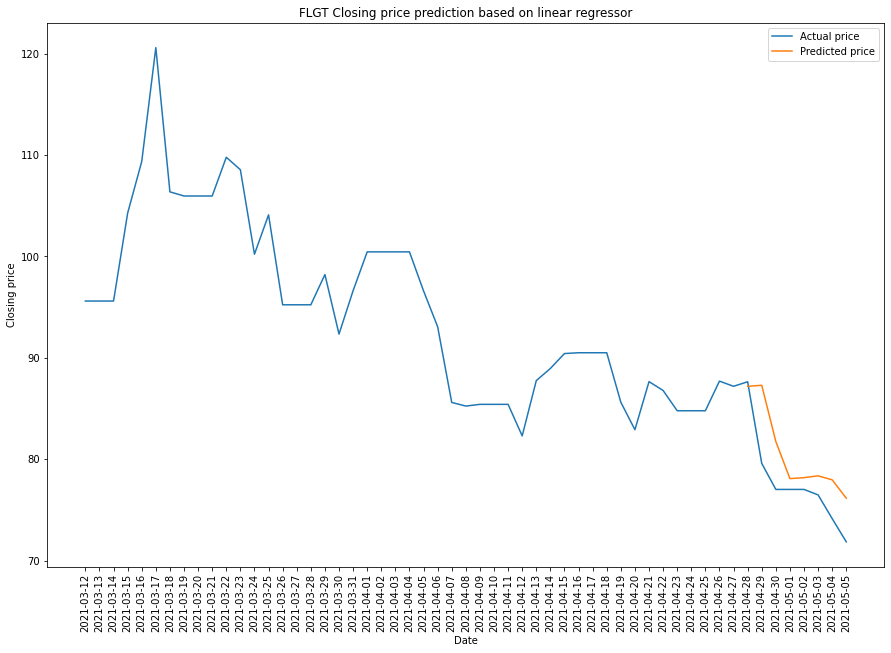

In [302]:
plt.figure(figsize=(15,10))
sns.lineplot(data = lr_flgt_df, x="date",y="closing_price_x",label="Actual price")
sns.lineplot(data=lr_flgt_df,x="date",y="prediction",label="Predicted price")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("FLGT Closing price prediction based on linear regressor")
plt.show()